In [2]:
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import LidarPointCloud
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl
import matplotlib as mpl
import json
from typing import Dict
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from pprint import pprint
from SimpleTrack.mot_3d.data_protos.bbox import *


from pathlib import Path

from visutils import *


plt.style.use('dark_background')


In [2]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/cv08f23/datasets/nuScenes/v1.0-trainval', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 22.7 seconds.
Reverse indexing ...
Done reverse indexing in 5.9 seconds.


In [3]:
det_names: List[str] = ["cp", "cp_0.06", "cp_0.06_11", "cp_0.075", "pp_0.16", "pp_0.16_12", "pp_m"]

scene_no = "0100"
# There are 7 labels: "bicycle" "bus" "car" "motorcycle" "pedestrian" "trailer" "truck"
labels = ["bicycle", "bus", "car", "motorcycle", "pedestrian", "trailer", "truck"]
label = "car"

# The preprocessing dir contains data generated by SimpleTrack's preprocessing pipeline.
# There are the following folders:
# - calib_info: Contains calibration information for each scene.
# - detection: Contains detections for each scene.
# - ego_info: Contains ego information for each scene.
# - gt_info: Contains ground truth information for each scene.
# - pc/raw_pc: Contains point clouds for each scene.
# - token_info: Contains token information for each scene.
# - ts_info: Contains timestamp information for each scene.

preprocessing_dir = Path("~/datasets/simpletrack/preprocessing/nuscenes_data/2hz").expanduser()
assert preprocessing_dir.exists(), f"Preprocessing dir {preprocessing_dir} does not exist."

calib_info_dir = preprocessing_dir / "calib_info"
assert calib_info_dir.exists(), f"Calib info dir {calib_info_dir} does not exist."
detection_dir = preprocessing_dir / "detection" / det_names[0] / "dets"
assert detection_dir.exists(), f"Detection dir {detection_dir} does not exist."
ego_info_dir = preprocessing_dir / "ego_info"
assert ego_info_dir.exists(), f"Ego info dir {ego_info_dir} does not exist."
pc_dir = preprocessing_dir / "pc" / "raw_pc"
assert pc_dir.exists(), f"PC dir {pc_dir} does not exist."
token_info_dir = preprocessing_dir / "token_info"
assert token_info_dir.exists(), f"Token info dir {token_info_dir} does not exist."
ts_info_dir = preprocessing_dir / "ts_info"
assert ts_info_dir.exists(), f"TS info dir {ts_info_dir} does not exist."
gt_info_dir = preprocessing_dir / "gt_info"
assert gt_info_dir.exists(), f"GT info dir {gt_info_dir} does not exist."
# tracking_path = f"/home/cv08f23/datasets/simpletrack/tracking/nuscenes_data/cp/debug/summary/{label}/scene-{scene_no}.npz"

tracking_dir = Path("~/datasets/simpletrack/tracking/nuscenes_data/cp/debug/summary").expanduser()
assert tracking_dir.exists(), f"Tracking dir {tracking_dir} does not exist."
label_tracking_dir = tracking_dir / label
assert label_tracking_dir.exists(), f"Label tracking dir {label_tracking_dir} does not exist."


In [4]:
files: Dict[str, List[Path]] = {
    "calib_info": sorted(calib_info_dir.glob("*")),
    "detection": sorted(detection_dir.glob("*")),
    "ego_info": sorted(ego_info_dir.glob("*")),
    "pc": sorted(pc_dir.glob("*")),
    "token_info": sorted(token_info_dir.glob("*")),
    "ts_info": sorted(ts_info_dir.glob("*")),
    "gt_info": sorted(gt_info_dir.glob("*")),
}

for l in labels:
    files[f"{l}_tracking"] = sorted(label_tracking_dir.glob("*"))

def allequal(*args) -> bool:
    return all([x == args[0] for x in args[1:]])

assert allequal(*[len(v) for v in files.values()]), f"Number of files in each dir must be the same. But got: {{k: len(v) for k, v in files.items()}}"

{k: len(v) for k, v in files.items()}

{'calib_info': 150,
 'detection': 150,
 'ego_info': 150,
 'pc': 150,
 'token_info': 150,
 'ts_info': 150,
 'gt_info': 150,
 'bicycle_tracking': 150,
 'bus_tracking': 150,
 'car_tracking': 150,
 'motorcycle_tracking': 150,
 'pedestrian_tracking': 150,
 'trailer_tracking': 150,
 'truck_tracking': 150}

In [5]:
# Load a scene.
scene_idx: int = 0
frame_idx: int = 0

In [6]:
pc_npz = np.load(files["pc"][scene_idx])
pc = pc_npz[pc_npz.files[frame_idx]]

assert len(pc.shape) == 2, f"Expected 2D array, but got {pc.shape}"
assert pc.shape[1] == 4, f"Expected 2D array with 4 columns (x,y,z,r), but got {pc.shape[1]} columns"

In [7]:
dets_npz = np.load(files["detection"][scene_idx], allow_pickle=True)
print(dets_npz.files)
dets: Dict[str, np.ndarray] = {
    "bboxes": dets_npz["bboxes"],
    "types": dets_npz["types"],
    "velos": dets_npz["velos"],
}

assert allequal(*[len(v) for v in dets.values()]), f"Number of detections must be the same. But got: {{k: len(v) for k, v in dets.items()}}"

# Expect there to be 40 detections. Because ...
{k: len(v) for k, v in dets.items()}

['bboxes', 'types', 'velos']


{'bboxes': 40, 'types': 40, 'velos': 40}

In [65]:
gt_info_npz = np.load(files["gt_info"][scene_idx], allow_pickle=True)
print(gt_info_npz.files)
gts: Dict[str, np.ndarray] = {
    "bboxes": gt_info_npz["bboxes"],
    "types": gt_info_npz["types"],
    "ids": gt_info_npz["ids"],
}

assert allequal(*[len(v) for v in gts.values()]), f"Number of ground truths must be the same. But got: {{k: len(v) for k, v in gts.items()}}"

# Expect there to be 40 ground truths. Because ...
{k: len(v) for k, v in gts.items()}

['ids', 'types', 'bboxes']


{'bboxes': 40, 'types': 40, 'ids': 40}

In [93]:
print(f"len(gts['bboxes'])       = {len(gts['bboxes'])}")
print(f"len(gts['bboxes'][0])    = {len(gts['bboxes'][0])}")
print(f"len(gts['bboxes'][0][0]) = {len(gts['bboxes'][0][0])}")
gts["bboxes"][0][0]
# xc, yc, zc, w, l, h, qx, qy, qz, qw

len(gts['bboxes'])       = 40
len(gts['bboxes'][0])    = 37
len(gts['bboxes'][0][0]) = 10


[242.87,
 926.036,
 0.898,
 1.726,
 4.257,
 1.489,
 0.787419398050721,
 0.0,
 0.0,
 -0.616417627565468]

In [96]:
@dataclass
class GroundTruth:
    bbox: BBox
    type: str
    tracking_id: int

gts_tracked: List[GroundTruth] = []
for bbox, type, id in zip(gts["bboxes"][frame_idx], gts["types"][frame_idx], gts["ids"][frame_idx]):
    xc, yc, zc, w, l, h, qx, qy, qz, qw = bbox
    bbox = BBox(x=xc, y=yc, z=zc, w=w, l=l, h=h, o=1.0)
    bbox.s = 1.0
    gts_tracked.append(GroundTruth(bbox, type, id))



In [43]:
# Don't know what this is.
calib_info_npz = np.load(files["calib_info"][scene_idx], allow_pickle=True)
# print(calib_info_npz.files) # "0", "1" ... "40"
calib_info = calib_info_npz[calib_info_npz.files[frame_idx]]
assert len(calib_info) == 7, f"Expected 7D array, (x,y,z,Qx,Qy,Qz,Qw), but got {calib_info.shape}"
# calib_info.shape
calib_info_T = calib_info[:3]
calib_info_Q = calib_info[3:]
calib_info_R = Quaternion(calib_info_Q).rotation_matrix
calib_info_tf = np.eye(4)
calib_info_tf[:3, :3] = calib_info_R
calib_info_tf[:3, 3] = calib_info_T
calib_info_tf

array([[ 0.00203327,  0.99970406,  0.02424172,  0.943713  ],
       [-0.99998053,  0.00217566, -0.00584864,  0.        ],
       [-0.00589965, -0.02422936,  0.99968902,  1.84023   ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [41]:
ego_info_npz = np.load(files["ego_info"][scene_idx], allow_pickle=True)
# print(ego_info_npz.files) # "0", "1" ... "40"
ego_info = ego_info_npz[ego_info_npz.files[frame_idx]]
assert len(ego_info) == 7, f"Expected 7D array (x,y,z, Qx, Qy, Qz, Qw), but got {len(ego_info)}"
T = ego_info[:3]
Q = ego_info[3:]
R = Quaternion(Q).rotation_matrix
# Create a 4x4 transformation matrix.
tf = np.eye(4)
tf[:3, :3] = R
tf[:3, 3] = T
(tf)

array([[ 9.93875513e-01,  1.10336270e-01,  6.11325451e-03,
         2.49896109e+02],
       [-1.10425507e-01,  9.93739704e-01,  1.69590231e-02,
         9.17552257e+02],
       [-4.20378837e-03, -1.75302171e-02,  9.99837497e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [145]:
car_tracking_npz = np.load(files["car_tracking"][scene_idx], allow_pickle=True)
print(car_tracking_npz.files)

car_tracking = {
    "ids": car_tracking_npz["ids"],
    "bboxes": car_tracking_npz["bboxes"],
    "states": car_tracking_npz["states"],
    "types": car_tracking_npz["types"],
}

assert allequal(*[len(v) for v in car_tracking.values()]), f"Number of car tracking must be the same. But got: {{k: len(v) for k, v in car_tracking.items()}}"

{k: len(v) for k, v in car_tracking.items()}

states = set()
for s in car_tracking["states"]:
    states.update(s)
states
# car_tracking["states"][frame_idx]

['ids', 'bboxes', 'states', 'types']


{'alive_0_1', 'alive_1_0'}

In [46]:
@dataclass
class Tracklet:
    bbox: BBox
    tracking_id: str
    state: str
    type: str

car_tracklets: List[Tracklet] = []
# for bbs, ids in zip(car_tracking["bboxes"][frame_idx], car_tracking["ids"][frame_idx]):
for bb, tid, state, type in zip(*[car_tracking[k][frame_idx] for k in ["bboxes", "ids", "states", "types"]]):
    x, y, z, w, l, h, o, s = bb
    bbox = BBox(x=x, y=y, z=z, w=w, l=l, h=h, o=o)
    bbox.s = s
    car_tracklets.append(Tracklet(bbox, tracking_id=tid, state=state, type=type))

pprint(car_tracklets[0])

Tracklet(bbox=<SimpleTrack.mot_3d.data_protos.bbox.BBox object at 0x7fc7e441e290>,
         tracking_id='0_0',
         state='alive_1_0',
         type='car')


In [47]:
import math
def quaternion_to_euler(quaternion: Quaternion) -> Tuple[float, float, float]:
    w, x, y, z = quaternion

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)

    return roll_x, pitch_y, yaw_z  # in radians

In [150]:
# Filled up by plot_tracklets()
generated_colors: Dict[str, Tuple[float, float, float]] = {} 

def plot(pc: np.ndarray | None, tracklets: List[Tracklet], zoom: float, tf: np.ndarray, calib_info_tf: np.ndarray | None, groundtruths: List[GroundTruth] | None = None, show: bool = True, save: bool = False, save_path: Optional[Path] = None) -> None:
    assert zoom > 0, f"Zoom must be positive, but got {zoom}"
    assert len(tf.shape) == 2, f"Expected 2D array, but got {tf.shape}"
    assert tf.shape == (4, 4), f"Expected 2D array with shape (4, 4), but got {tf.shape}"
    if calib_info_tf is not None:
        assert len(calib_info_tf.shape) == 2, f"Expected 2D array, but got {calib_info_tf.shape}"
        assert calib_info_tf.shape == (4, 4), f"Expected 2D array with shape (4, 4), but got {calib_info_tf.shape}"

    T = tf[:3, 3]
    R = tf[:3, :3]

    # Print the rotation as roll, pitch, yaw.
    roll, pitch, yaw = quaternion_to_euler(Quaternion(matrix=R))
    print(f"Q = Roll: {roll:.2f}, Pitch: {pitch:.2f}, Yaw: {yaw:.2f}")
    rollT, pitchT, yawT = quaternion_to_euler(Quaternion(matrix=R.T))
    print(f"Q.T = roll: {rollT:.2f}, pitch: {pitchT:.2f}, yaw: {yawT:.2f}")
    pprint({"T": T, "R": R})
    
    figsize = (12, 12)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    lim = (-100 / zoom, 100 / zoom) 
    ax.set_xlim3d(lim[0], lim[1])
    ax.set_ylim3d(lim[0], lim[1])
    ax.set_zlim3d(lim[0], lim[1])
    ax.set_axis_off()

    ax.set_aspect("equal", adjustable="box")
    
    # Set the perspective of the camera.
    # ax.view_init(elev=60, azim=30)
    

    global generated_colors

    # Plot point cloud.
    def plot_pointcloud(pc: np.ndarray) -> None:
        assert len(pc.shape) == 2, f"Expected 2D array, but got {pc.shape}"
        assert pc.shape[1] == 4, f"Expected 2D array with 4 columns (x,y,z,r), but got {pc.shape[1]} columns"
        # Rotate and translate point cloud.
        pc_translated = pc[:, :3]
        calib_info_R = calib_info_tf[:3, :3]
        pc_transformed = np.dot(pc_translated, calib_info_R)
        ax.scatter3D(pc_transformed[:, 0], pc_transformed[:, 1], pc_transformed[:, 2], s=0.4, c="white", edgecolors="none", alpha=1, cmap='jet')



    def plot_tracklets_without_rotating(tracklets: List[Tracklet]) -> None:
        for tracklet in tracklets:
            corners = np.array(BBox.box2corners3d(tracklet.bbox))  
            corners_translated = corners - T
            corners_transformed = corners_translated
            
            global generated_colors
            tid: str = tracklet.tracking_id
            if tid not in generated_colors:
                generated_colors[tid] = generate_hsv_color()
            color = generated_colors[tid]


            line_color = color
            line_alpha = 1
            line_width = 1.25

            # plot 12 lines of bounding box
            plot_line = lambda x, y, z: ax.plot3D(x, y, z, c=line_color, alpha=line_alpha, linewidth=line_width)

            # the first 4 corners are the "upper" corners
            upper_corners = corners_transformed[:4, :]
            plot_line(upper_corners[:, 0], upper_corners[:, 1], upper_corners[:, 2])
            # Plot the missing line connecting the upper face
            plot_line([upper_corners[0, 0], upper_corners[3, 0]], [upper_corners[0, 1], upper_corners[3, 1]], [upper_corners[0, 2], upper_corners[3, 2]])
            # the last 4 corners are the "bottom" corners
            lower_corners = corners_transformed[4:, :]
            plot_line(lower_corners[:, 0], lower_corners[:, 1], lower_corners[:, 2])
            # Plot the missing line connecting the lower face
            plot_line([lower_corners[0, 0], lower_corners[3, 0]], [lower_corners[0, 1], lower_corners[3, 1]], [lower_corners[0, 2], lower_corners[3, 2]])
            # Plot the lines connecting both faces
            plot_line([upper_corners[0, 0], lower_corners[2, 0]], [upper_corners[0, 1], lower_corners[2, 1]], [upper_corners[0, 2], lower_corners[2, 2]])
            plot_line([upper_corners[1, 0], lower_corners[3, 0]], [upper_corners[1, 1], lower_corners[3, 1]], [upper_corners[1, 2], lower_corners[3, 2]])
            plot_line([upper_corners[2, 0], lower_corners[0, 0]], [upper_corners[2, 1], lower_corners[0, 1]], [upper_corners[2, 2], lower_corners[0, 2]])
            plot_line([upper_corners[3, 0], lower_corners[1, 0]], [upper_corners[3, 1], lower_corners[1, 1]], [upper_corners[3, 2], lower_corners[1, 2]])


    
    def plot_tracklets(tracklets: List[Tracklet]) -> None:
        for tracklet in tracklets:
            corners = np.array(BBox.box2corners3d(tracklet.bbox))

            corners_translated = corners - T

            corners_transformed = np.dot(corners_translated, R)

            global generated_colors            
            tid: str = tracklet.tracking_id
            if tid not in generated_colors:
                generated_colors[tid] = generate_hsv_color()
            color = generated_colors[tid]


            line_color = color
            line_alpha = 1
            line_width = 1.25

            # plot 12 lines of bounding box
            plot_line = lambda x, y, z: ax.plot3D(x, y, z, c=line_color, alpha=line_alpha, linewidth=line_width)

            # the first 4 corners are the "upper" corners
            upper_corners = corners_transformed[:4, :]
            plot_line(upper_corners[:, 0], upper_corners[:, 1], upper_corners[:, 2])
            # Plot the missing line connecting the upper face
            plot_line([upper_corners[0, 0], upper_corners[3, 0]], [upper_corners[0, 1], upper_corners[3, 1]], [upper_corners[0, 2], upper_corners[3, 2]])
            # the last 4 corners are the "bottom" corners
            lower_corners = corners_transformed[4:, :]
            plot_line(lower_corners[:, 0], lower_corners[:, 1], lower_corners[:, 2])
            # Plot the missing line connecting the lower face
            plot_line([lower_corners[0, 0], lower_corners[3, 0]], [lower_corners[0, 1], lower_corners[3, 1]], [lower_corners[0, 2], lower_corners[3, 2]])
            # Plot the lines connecting both faces
            plot_line([upper_corners[0, 0], lower_corners[2, 0]], [upper_corners[0, 1], lower_corners[2, 1]], [upper_corners[0, 2], lower_corners[2, 2]])
            plot_line([upper_corners[1, 0], lower_corners[3, 0]], [upper_corners[1, 1], lower_corners[3, 1]], [upper_corners[1, 2], lower_corners[3, 2]])
            plot_line([upper_corners[2, 0], lower_corners[0, 0]], [upper_corners[2, 1], lower_corners[0, 1]], [upper_corners[2, 2], lower_corners[0, 2]])
            plot_line([upper_corners[3, 0], lower_corners[1, 0]], [upper_corners[3, 1], lower_corners[1, 1]], [upper_corners[3, 2], lower_corners[1, 2]])

    def plot_groundtruths(gts: List[GroundTruth]) -> None:
        for gt in groundtruths:
            corners = np.array(BBox.box2corners3d(gt.bbox))  
            corners_translated = corners - T
            corners_transformed = np.dot(corners_translated, R)
            
            color = (1, 1, 1)
            # tid: str = gt.tracking_id
            # if tid not in generated_colors:
            #     generated_colors[tid] = generate_hsv_color()
            # color = generated_colors[tid]


            line_color = color
            line_alpha = 1
            line_width = 1.25

            # plot 12 lines of bounding box
            plot_line = lambda x, y, z: ax.plot3D(x, y, z, c=line_color, alpha=line_alpha, linewidth=line_width)

            # the first 4 corners are the "upper" corners
            upper_corners = corners_transformed[:4, :]
            plot_line(upper_corners[:, 0], upper_corners[:, 1], upper_corners[:, 2])
            # Plot the missing line connecting the upper face
            plot_line([upper_corners[0, 0], upper_corners[3, 0]], [upper_corners[0, 1], upper_corners[3, 1]], [upper_corners[0, 2], upper_corners[3, 2]])
            # the last 4 corners are the "bottom" corners
            lower_corners = corners_transformed[4:, :]
            plot_line(lower_corners[:, 0], lower_corners[:, 1], lower_corners[:, 2])
            # Plot the missing line connecting the lower face
            plot_line([lower_corners[0, 0], lower_corners[3, 0]], [lower_corners[0, 1], lower_corners[3, 1]], [lower_corners[0, 2], lower_corners[3, 2]])
            # Plot the lines connecting both faces
            plot_line([upper_corners[0, 0], lower_corners[2, 0]], [upper_corners[0, 1], lower_corners[2, 1]], [upper_corners[0, 2], lower_corners[2, 2]])
            plot_line([upper_corners[1, 0], lower_corners[3, 0]], [upper_corners[1, 1], lower_corners[3, 1]], [upper_corners[1, 2], lower_corners[3, 2]])
            plot_line([upper_corners[2, 0], lower_corners[0, 0]], [upper_corners[2, 1], lower_corners[0, 1]], [upper_corners[2, 2], lower_corners[0, 2]])
            plot_line([upper_corners[3, 0], lower_corners[1, 0]], [upper_corners[3, 1], lower_corners[1, 1]], [upper_corners[3, 2], lower_corners[1, 2]])


    if pc is not None:
        plot_pointcloud(pc)
    plot_tracklets(tracklets)
    # plot_tracklets_without_rotating(tracklets)

    if groundtruths is not None:
        plot_groundtruths(groundtruths)
    
    if save:
        assert save_path is not None, "Save path must be provided. Example path: Path('path/to/save.png')"
        plt.savefig(save_path)
    if show:
        plt.show()


In [88]:
print(f"There are {len(car_tracklets)} tracklets in this sequence.")

There are 45 tracklets in this sequence.


Q = Roll: -0.00, Pitch: 0.02, Yaw: -0.09
Q.T = roll: -0.00, pitch: -0.02, yaw: 0.09
{'R': array([[ 9.96183636e-01,  8.55878137e-02,  1.71139950e-02],
       [-8.55751946e-02,  9.96330631e-01, -1.46966916e-03],
       [-1.71769832e-02, -4.73088205e-07,  9.99852465e-01]]),
 'T': array([278.73819264, 915.52757405,   0.        ])}


/tmp/ipykernel_432225/3895623865.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(pc_transformed[:, 0], pc_transformed[:, 1], pc_transformed[:, 2], s=0.4, c="white", edgecolors="none", alpha=1, cmap='jet')


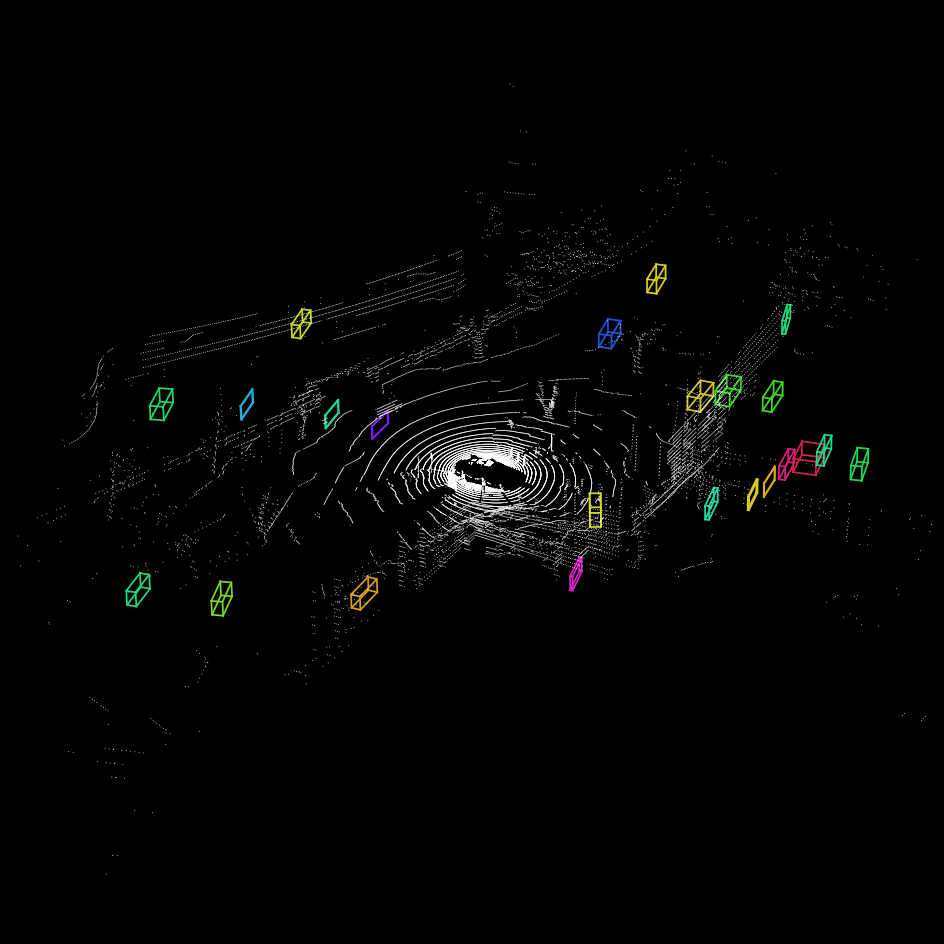

In [151]:
# tf_combined = np.dot(tf, calib_info_tf)
tf_combined = tf
score_threshold = 0.0
plot(pc, [tkl for tkl in car_tracklets if tkl.bbox.s > score_threshold], zoom=3 ,tf=tf_combined, calib_info_tf=calib_info_tf, show=True, save=False, save_path=None)

Q = Roll: -0.03, Pitch: -0.01, Yaw: -1.68
Q.T = roll: 0.01, pitch: -0.03, yaw: 1.68
{'R': array([[-0.10834937,  0.99367332,  0.02955929],
       [-0.99404493, -0.1086417 ,  0.00846482],
       [ 0.01162264, -0.0284661 ,  0.99952719]]),
 'T': array([250.84529235, 917.47925583,   1.83596379])}
Generated image [0000/0040]: /home/cv08f23/visualizations/frame_0000_th_0.5.png
Q = Roll: -0.03, Pitch: -0.01, Yaw: -1.68
Q.T = roll: 0.01, pitch: -0.03, yaw: 1.68
{'R': array([[-0.11117491,  0.99337852,  0.02897005],
       [-0.9937354 , -0.11145491,  0.0082316 ],
       [ 0.01140595, -0.02787342,  0.99954639]]),
 'T': array([250.82070723, 917.48270887,   1.83653422])}
Generated image [0001/0040]: /home/cv08f23/visualizations/frame_0001_th_0.5.png
Q = Roll: -0.03, Pitch: -0.01, Yaw: -1.68
Q.T = roll: 0.01, pitch: -0.03, yaw: 1.68
{'R': array([[-0.11250109,  0.99322518,  0.02910745],
       [-0.99358845, -0.11277593,  0.0079743 ],
       [ 0.01120289, -0.0280237 ,  0.99954448]]),
 'T': array([250.8

/tmp/ipykernel_432225/194653147.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


Generated image [0020/0040]: /home/cv08f23/visualizations/frame_0020_th_0.5.png
Q = Roll: -0.04, Pitch: 0.00, Yaw: -1.69
Q.T = roll: -0.01, pitch: -0.03, yaw: 1.69
{'R': array([[-0.11785788,  0.99243474,  0.03439186],
       [-0.99301935, -0.11762194, -0.00881187],
       [-0.00469997, -0.03519033,  0.99936958]]),
 'T': array([260.50503109, 916.69680524,   1.82977208])}
Generated image [0021/0040]: /home/cv08f23/visualizations/frame_0021_th_0.5.png
Q = Roll: -0.02, Pitch: 0.00, Yaw: -1.68
Q.T = roll: -0.00, pitch: -0.02, yaw: 1.68
{'R': array([[-0.11190005,  0.99347634,  0.0219803 ],
       [-0.99371635, -0.1118169 , -0.00497987],
       [-0.00248961, -0.02239943,  0.999746  ]]),
 'T': array([261.16588305, 916.64044689,   1.84195048])}
Generated image [0022/0040]: /home/cv08f23/visualizations/frame_0022_th_0.5.png
Q = Roll: -0.03, Pitch: 0.00, Yaw: -1.67
Q.T = roll: -0.01, pitch: -0.03, yaw: 1.67
{'R': array([[-0.1031737 ,  0.99412607,  0.03268846],
       [-0.99466074, -0.10304235, -0

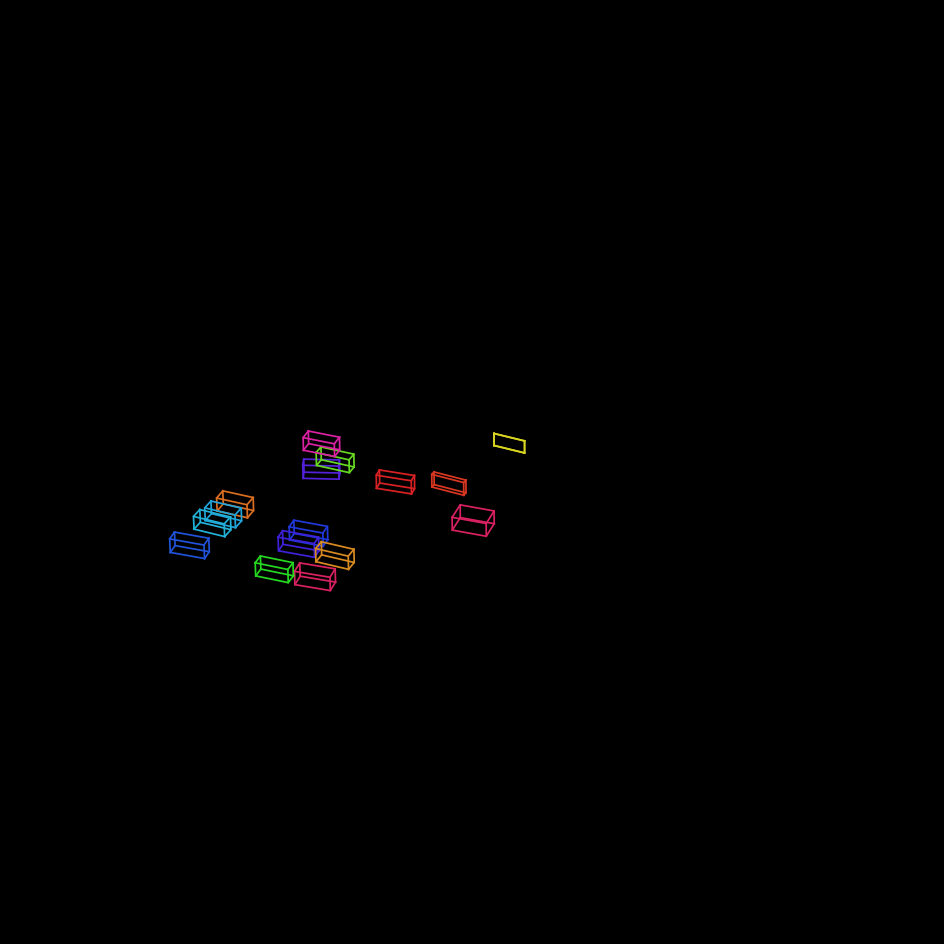

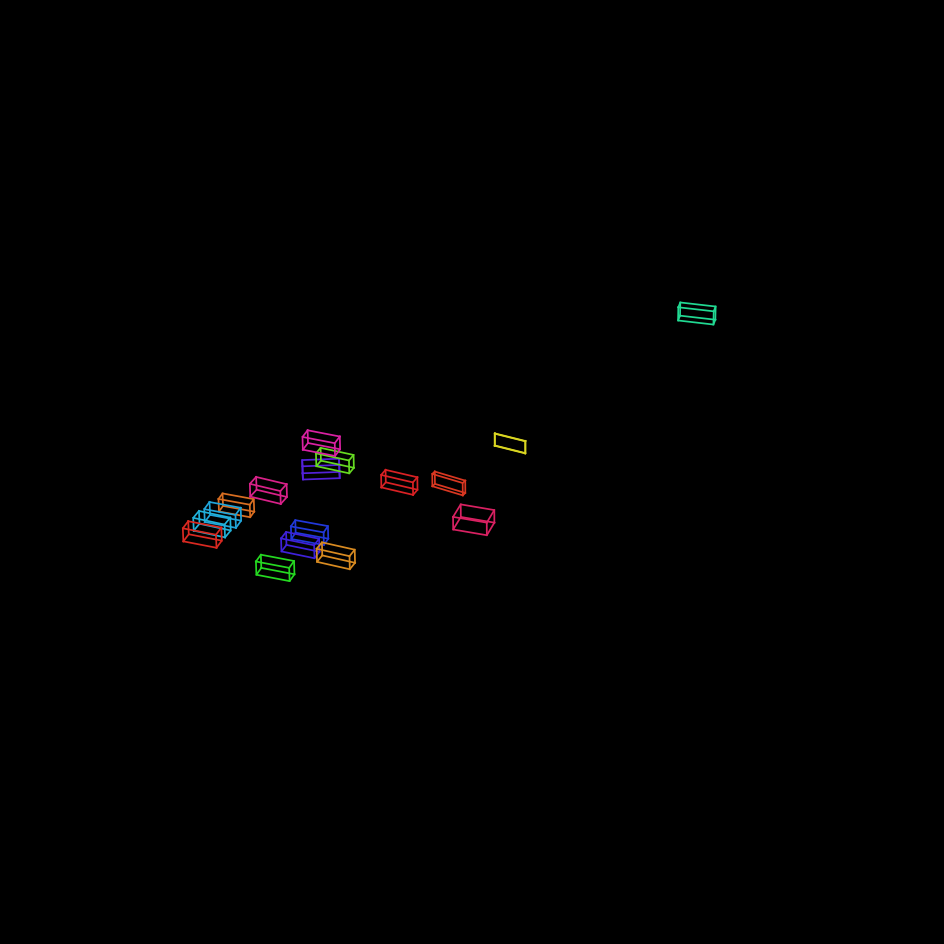

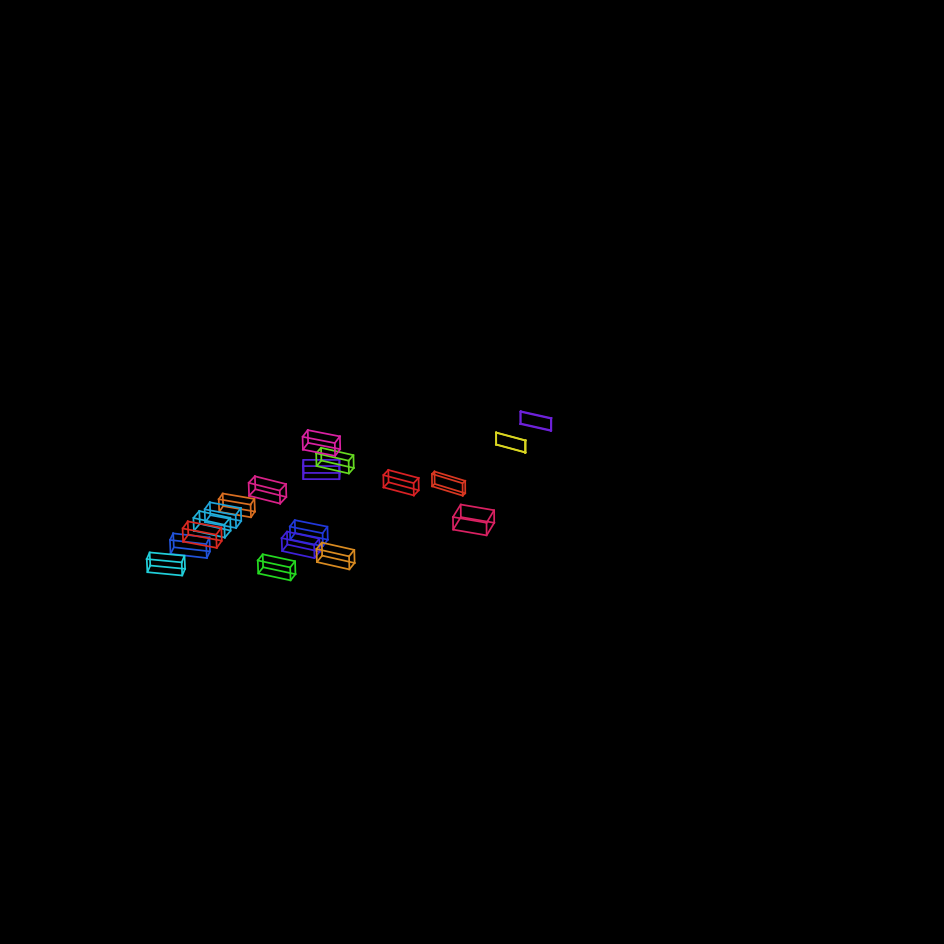

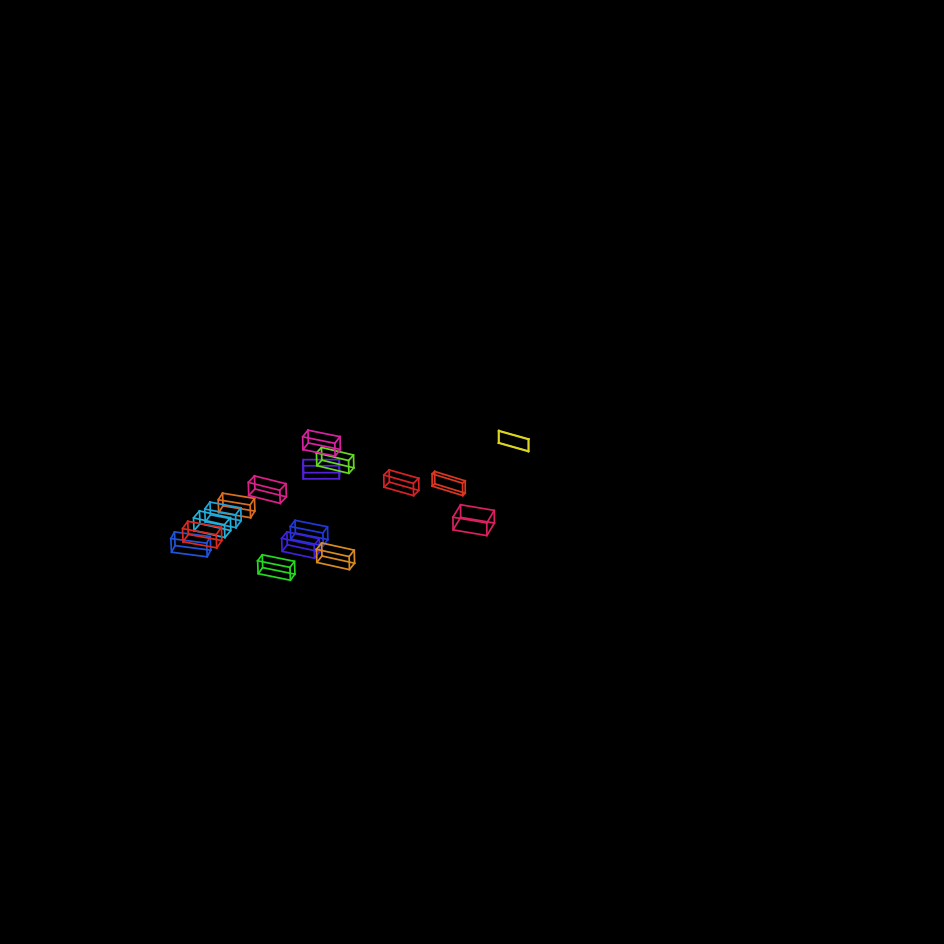

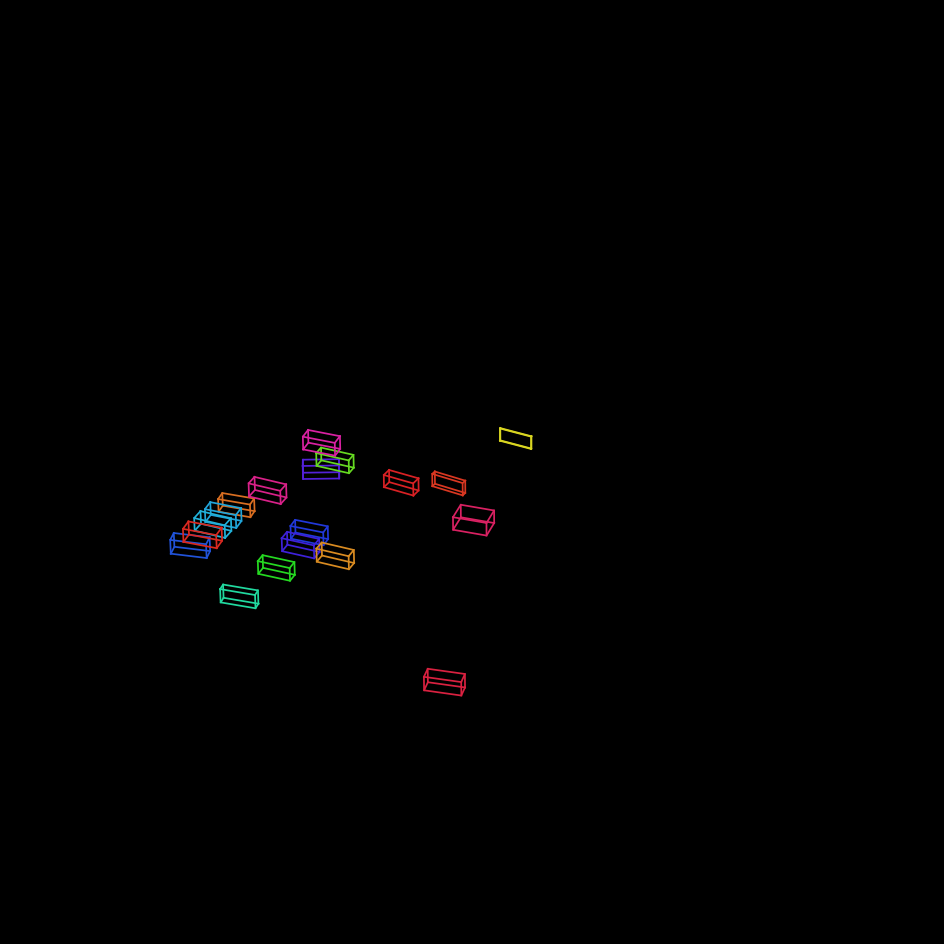

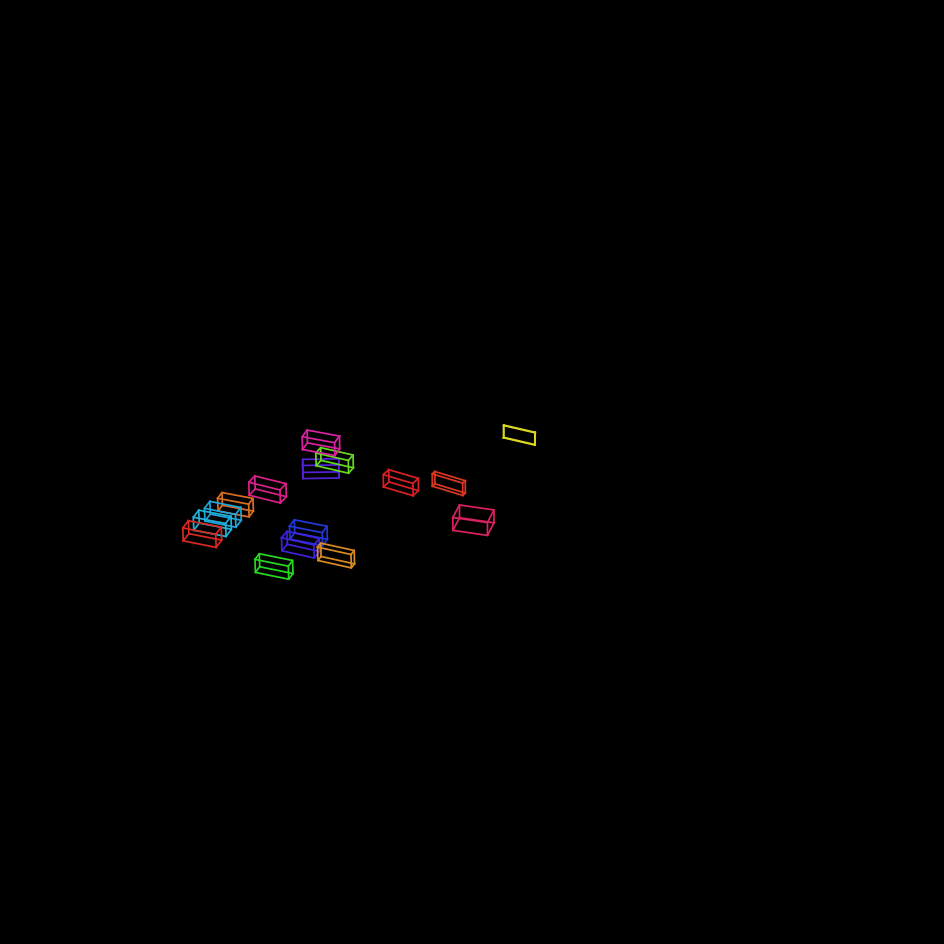

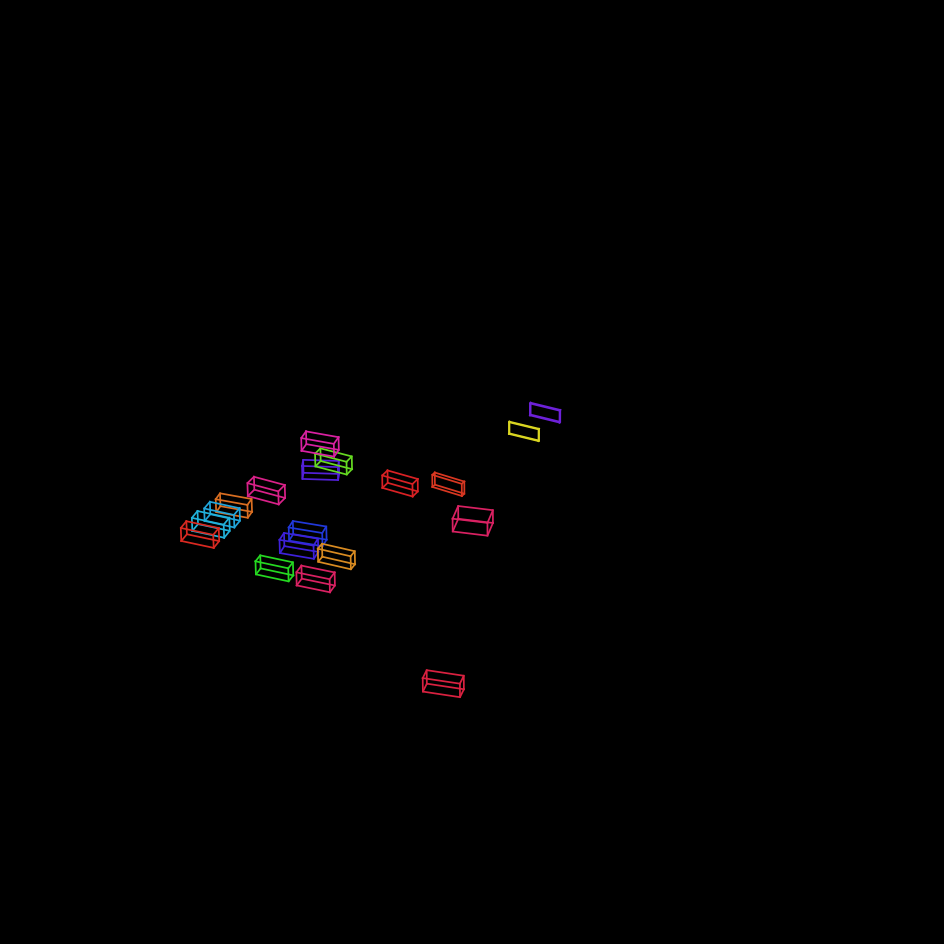

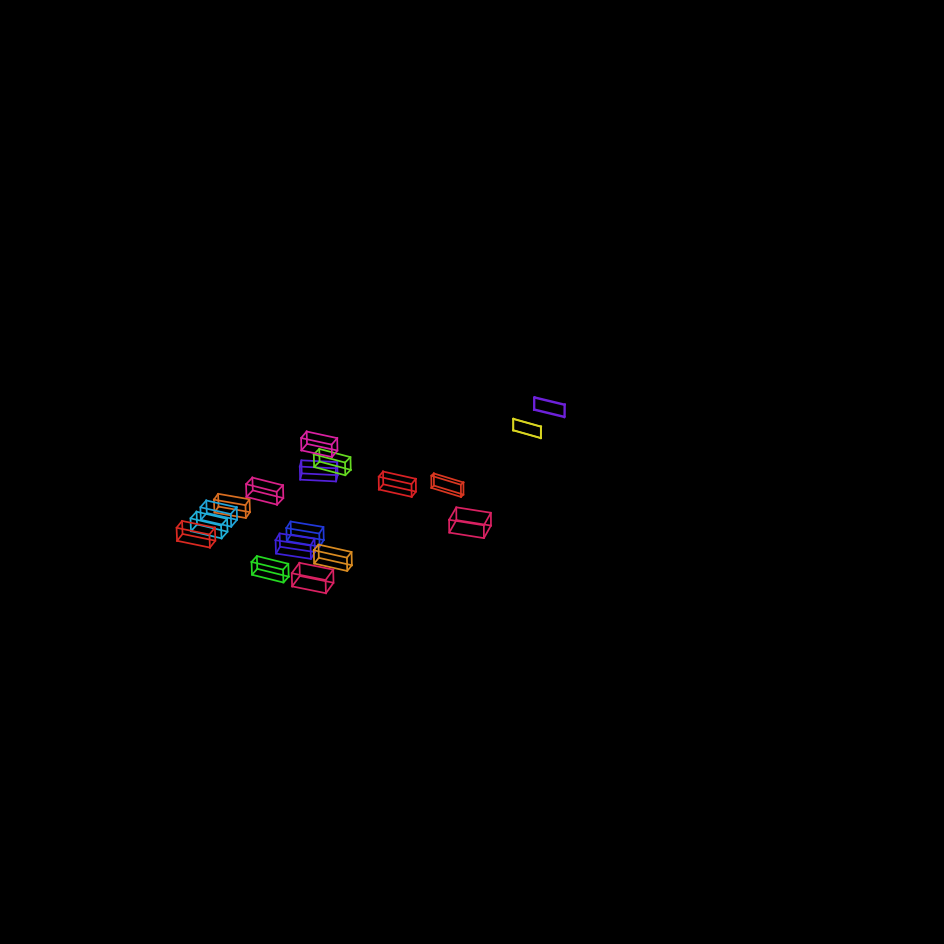

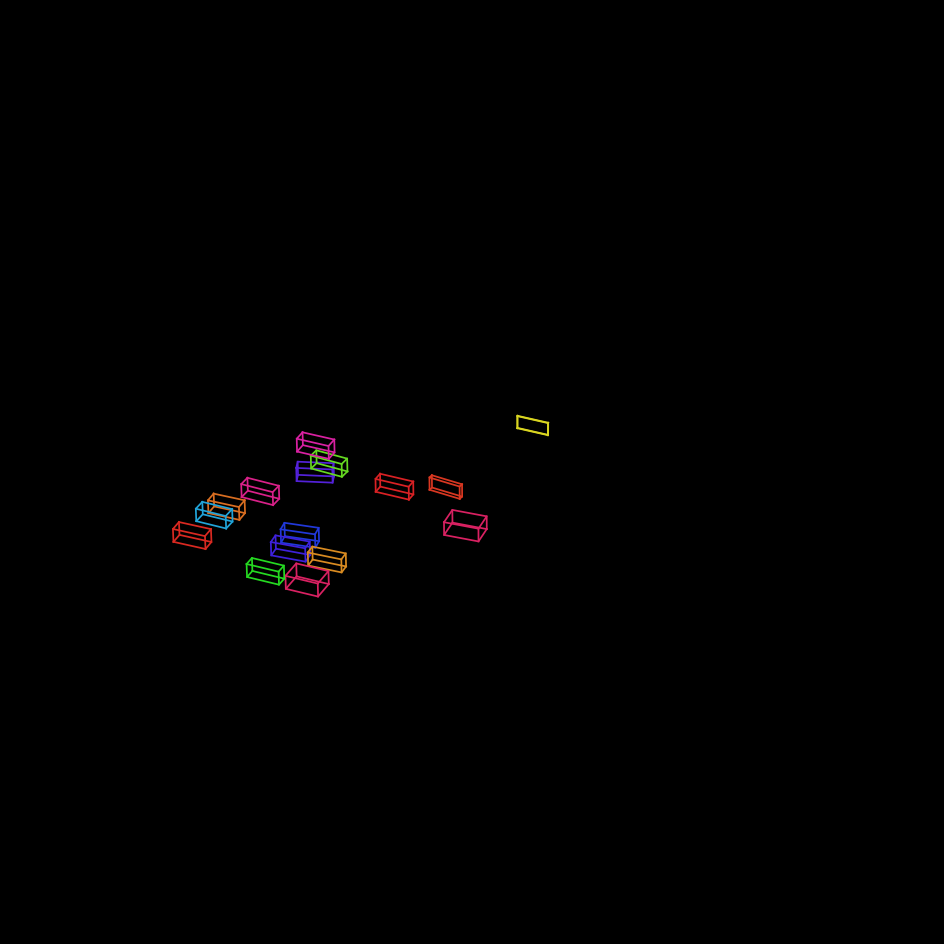

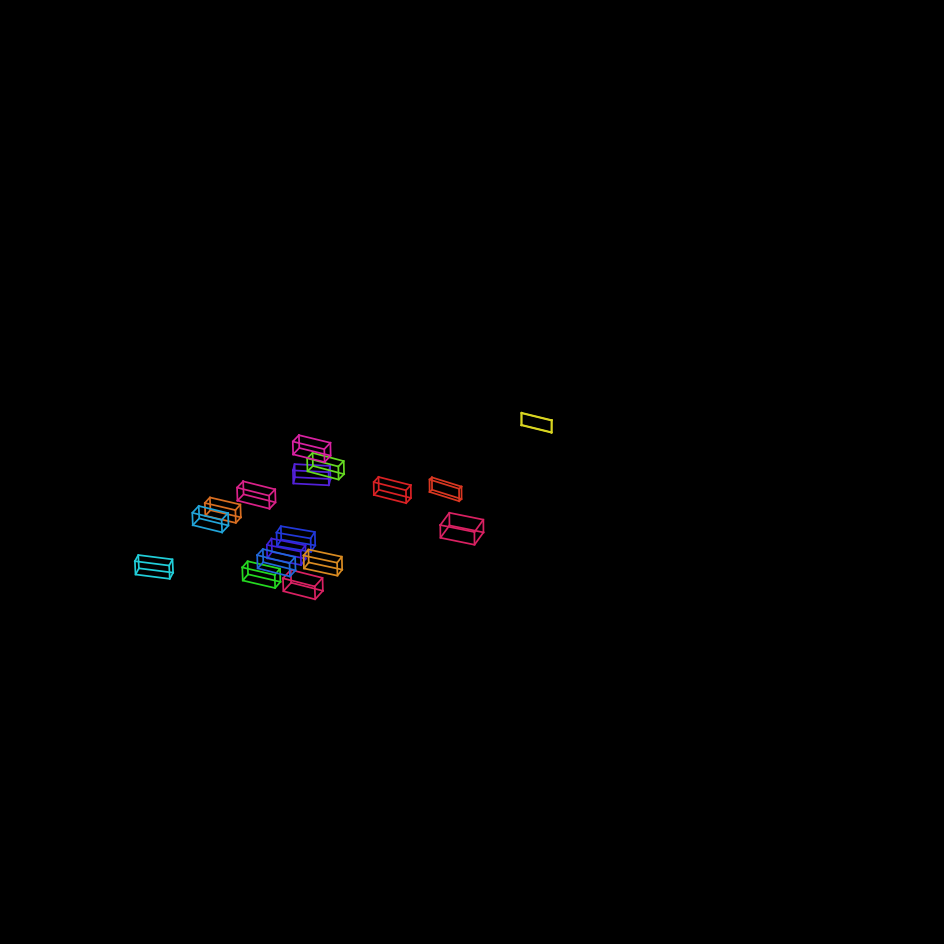

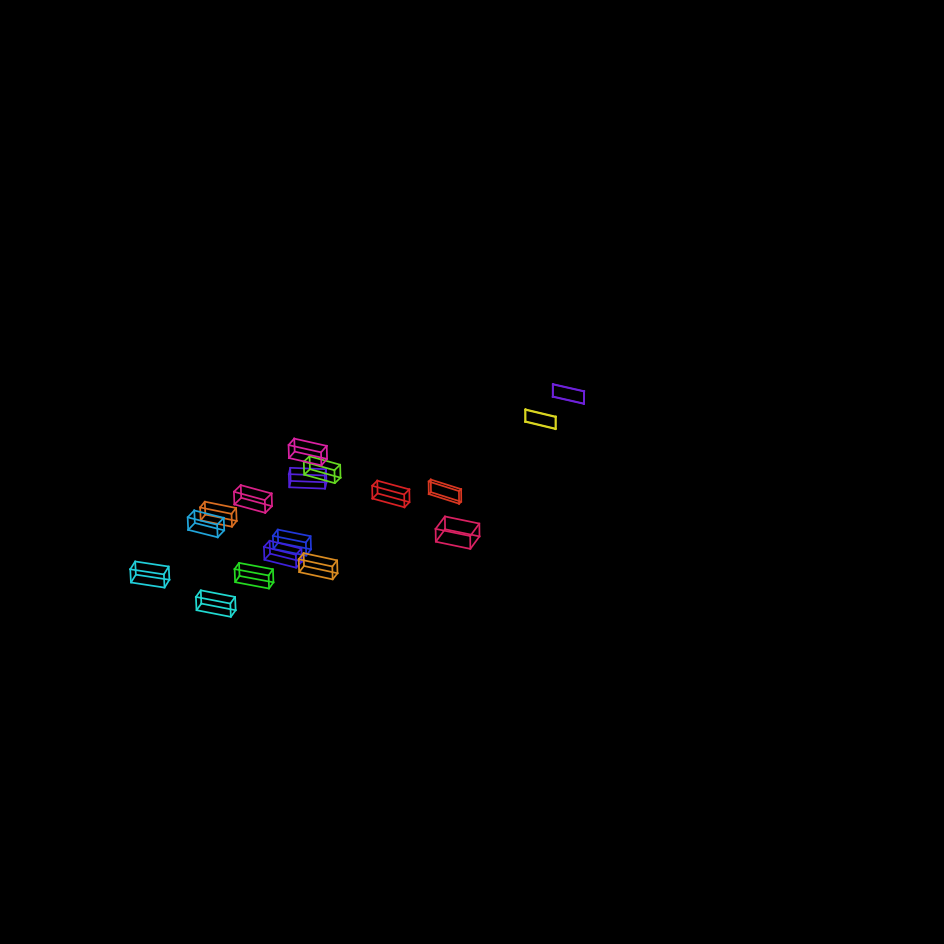

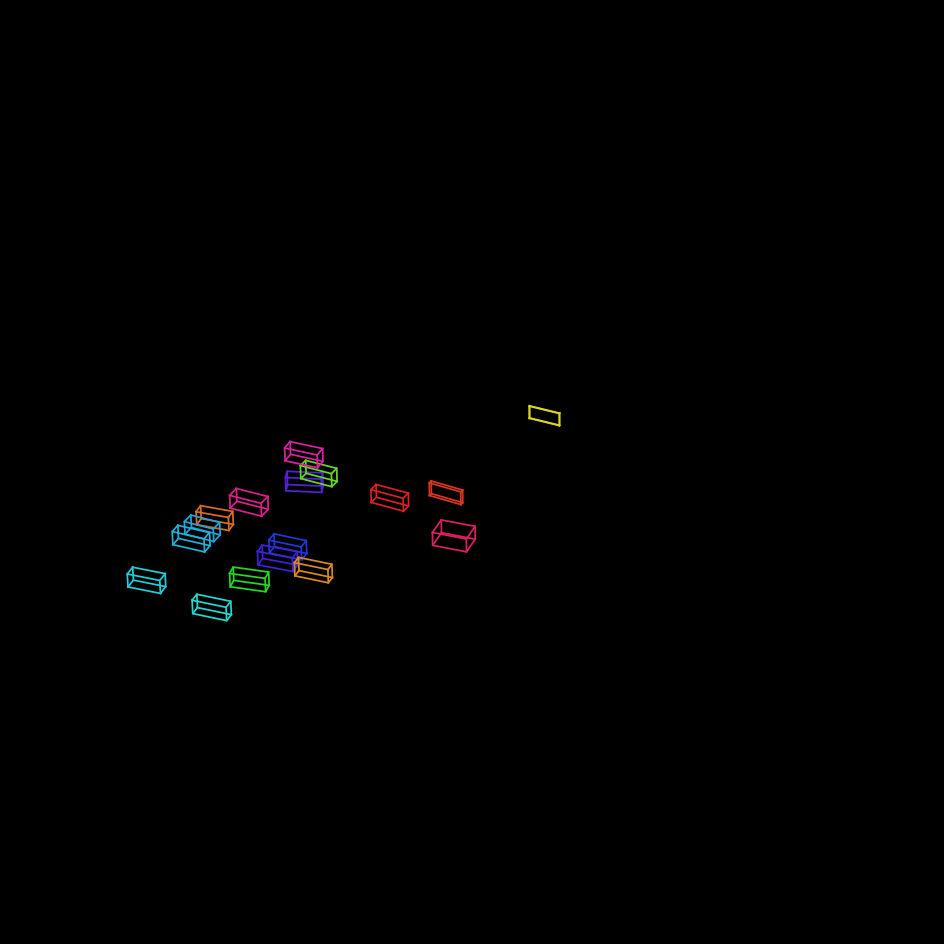

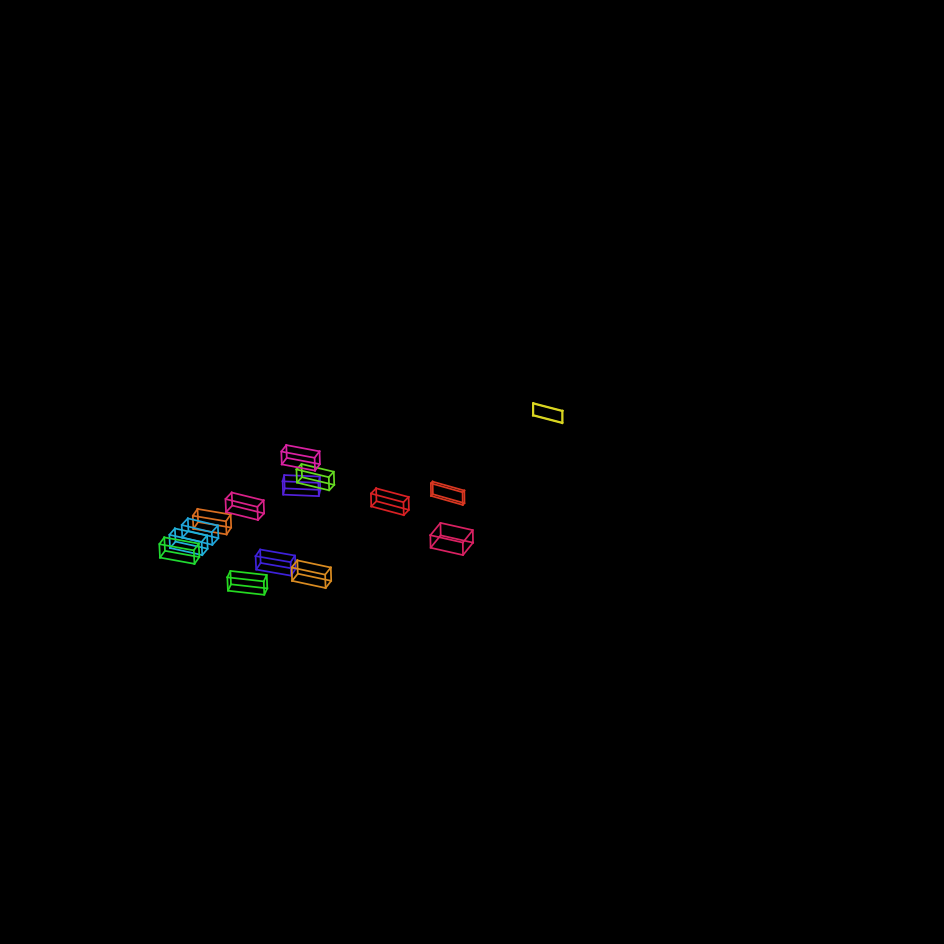

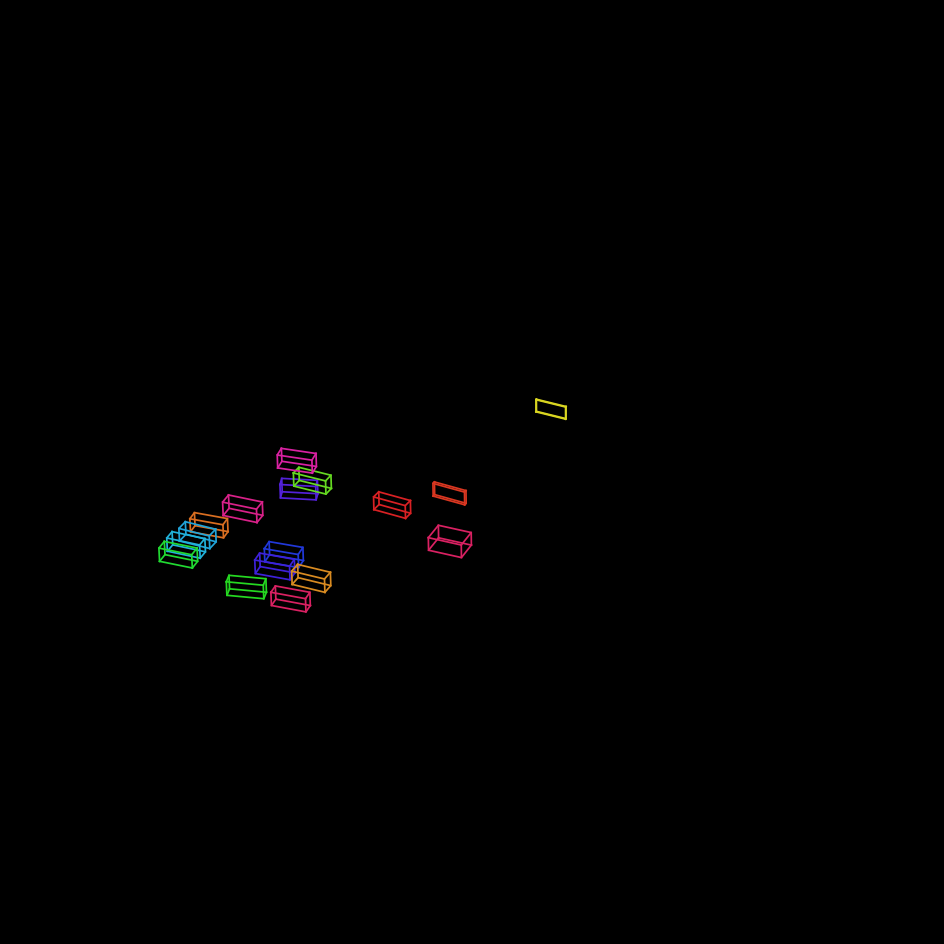

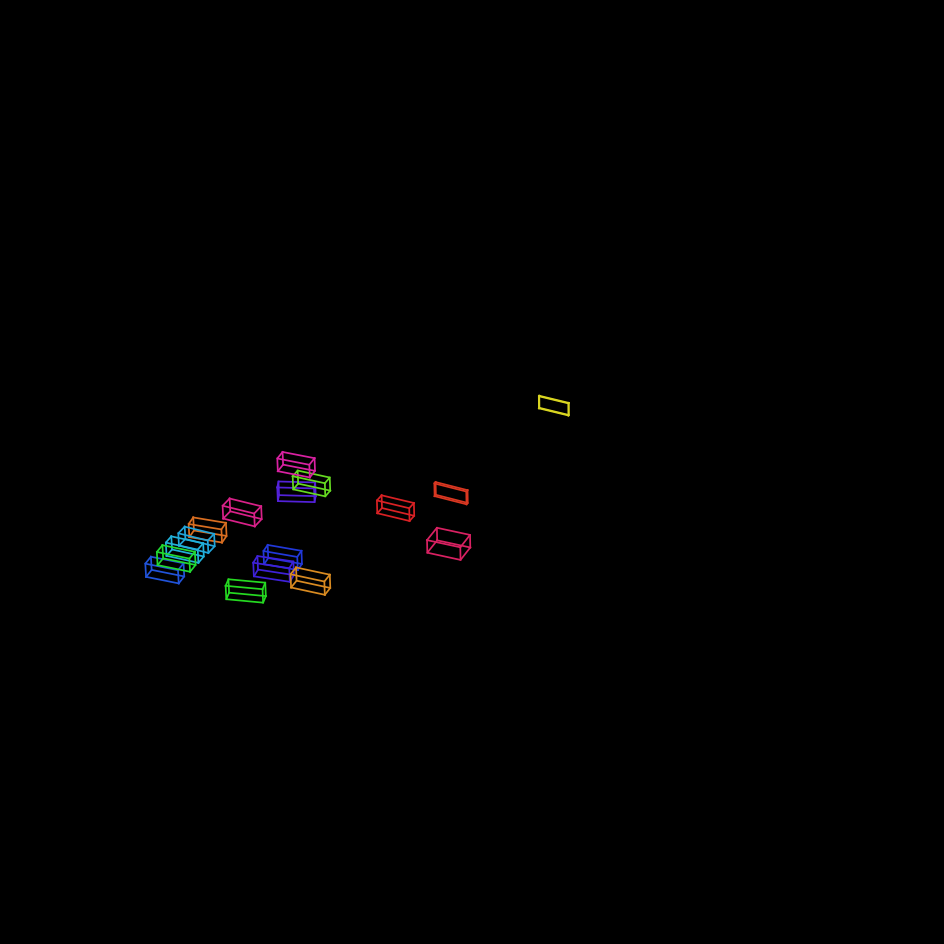

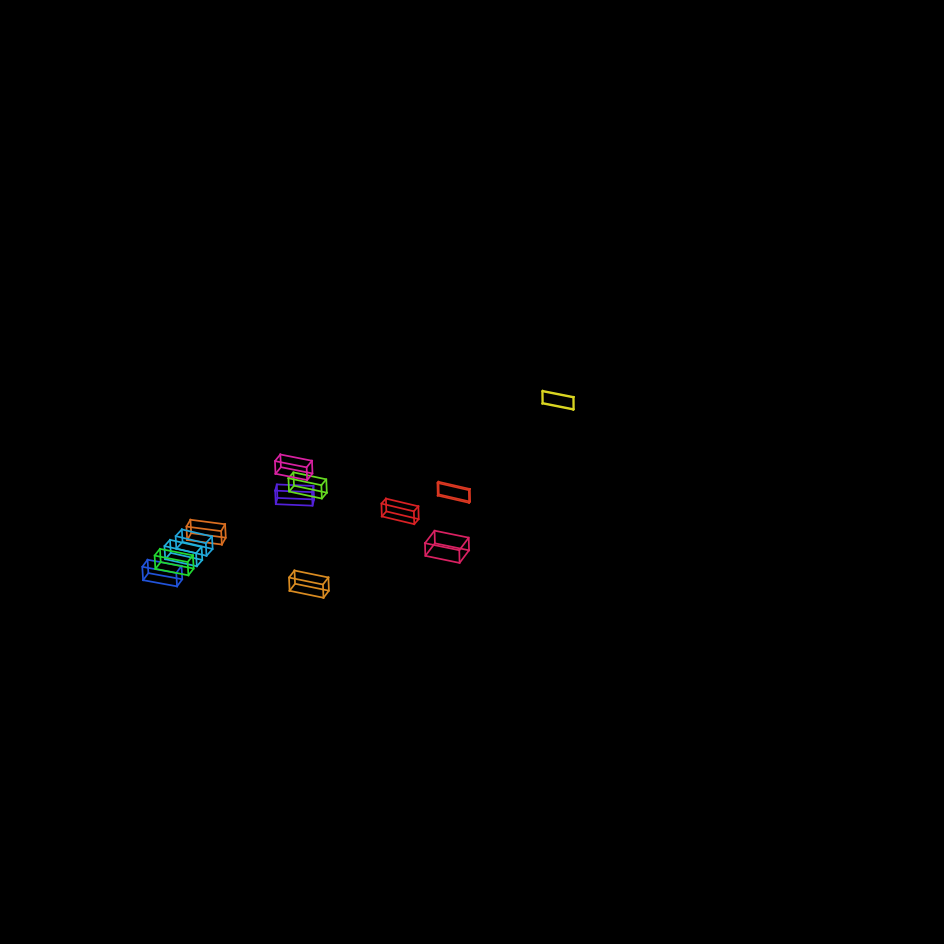

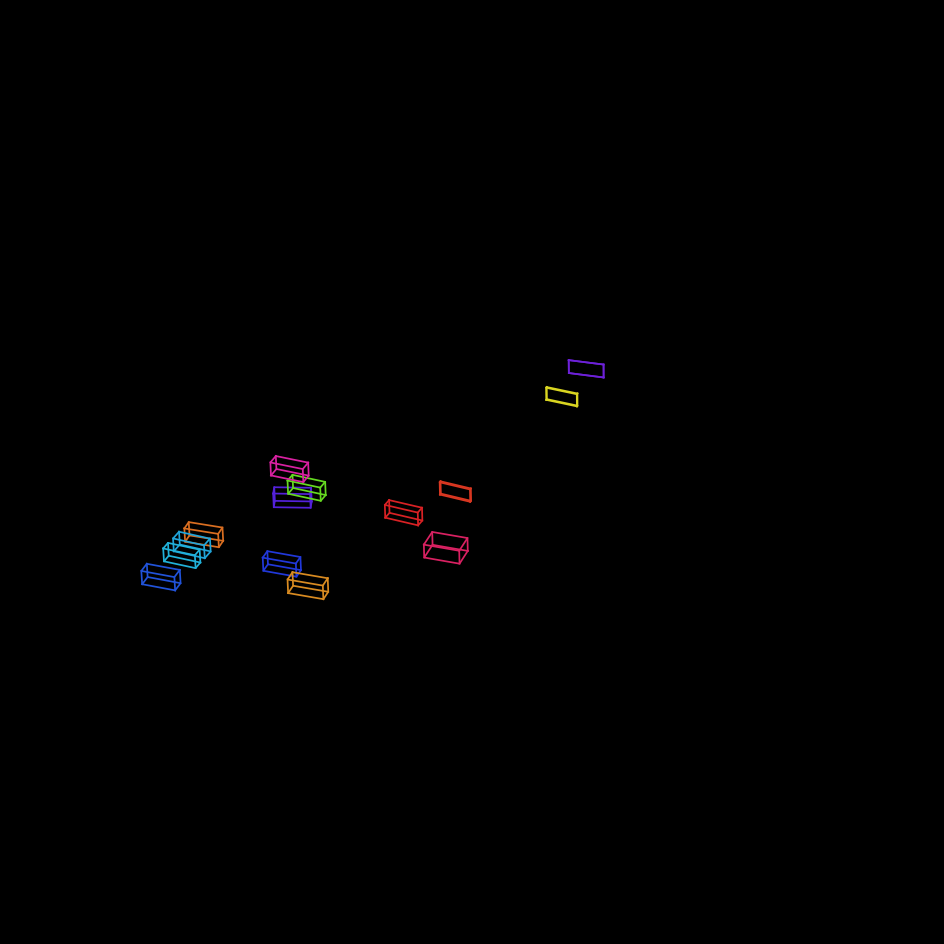

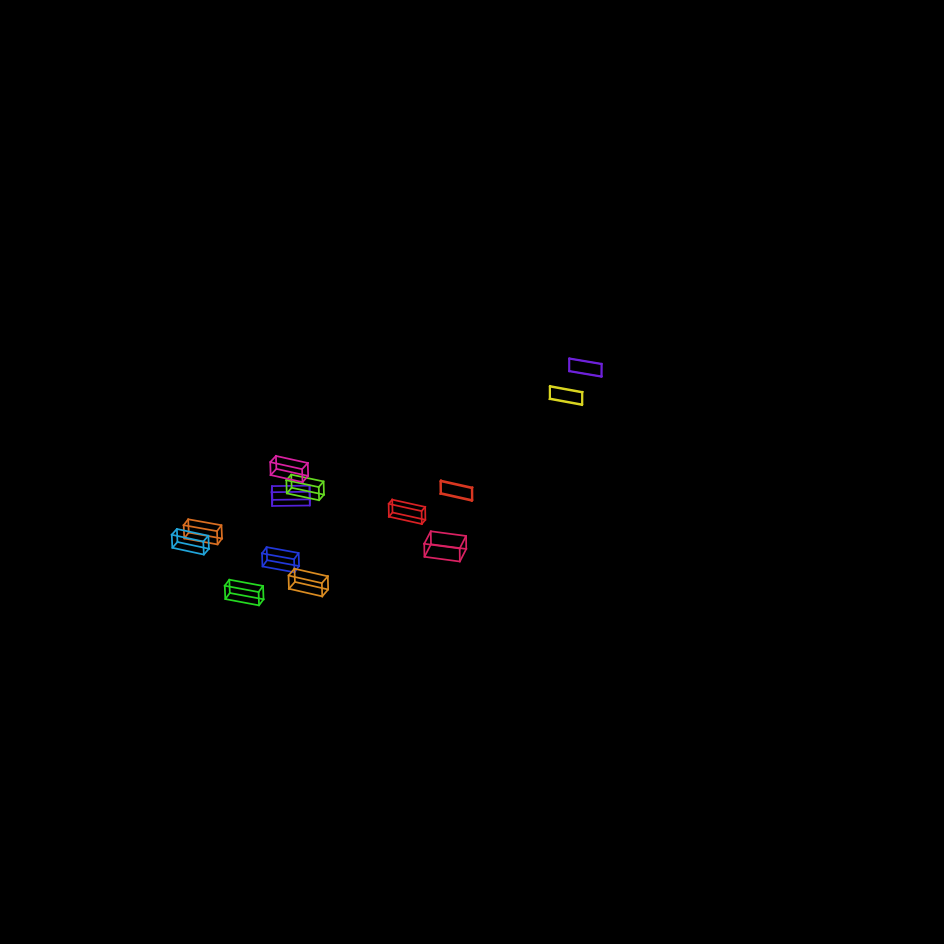

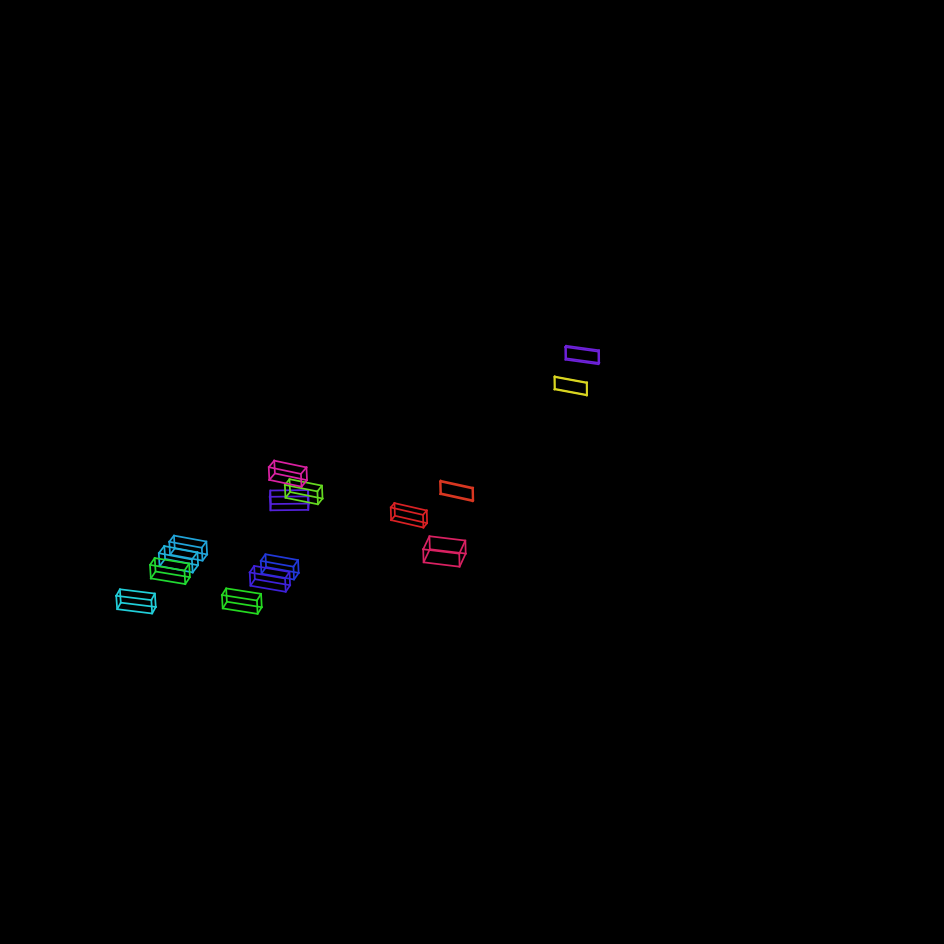

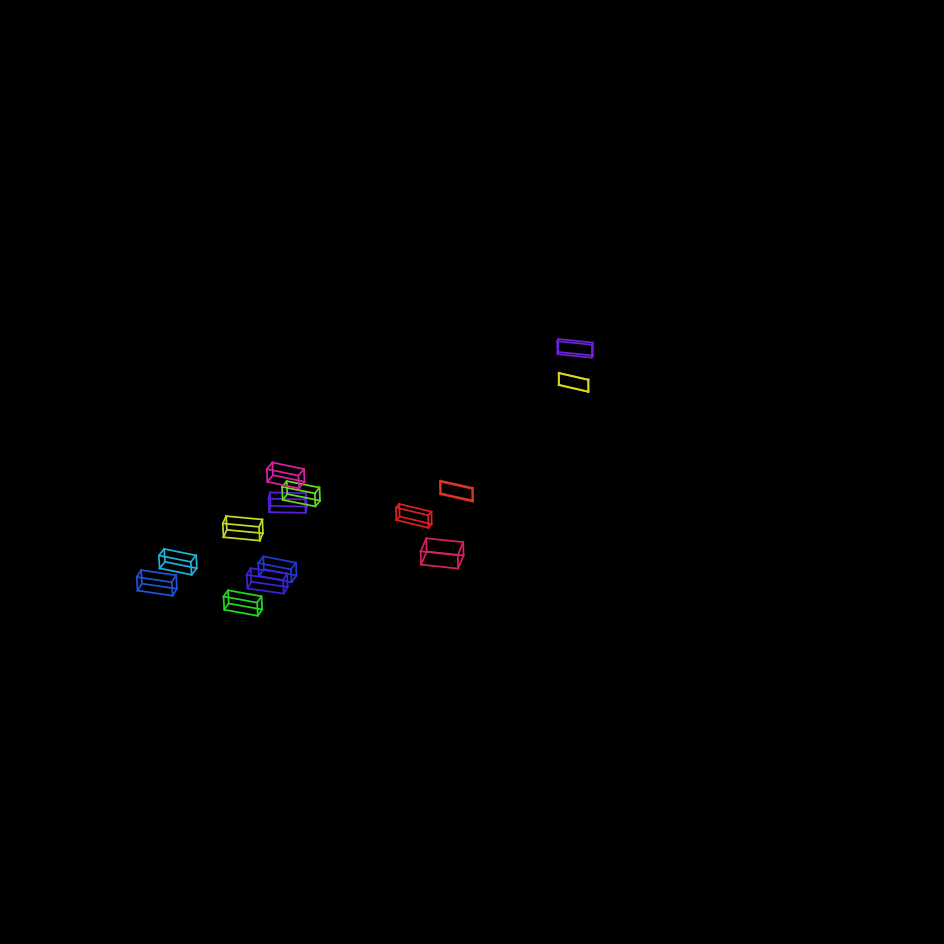

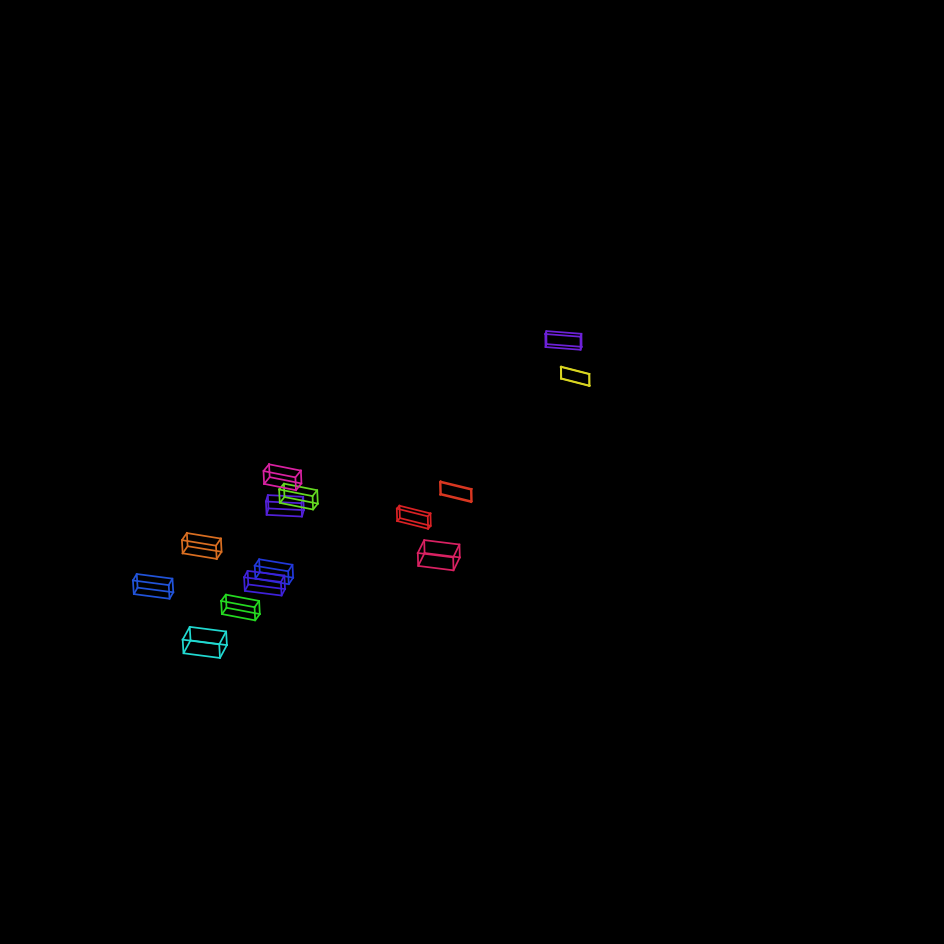

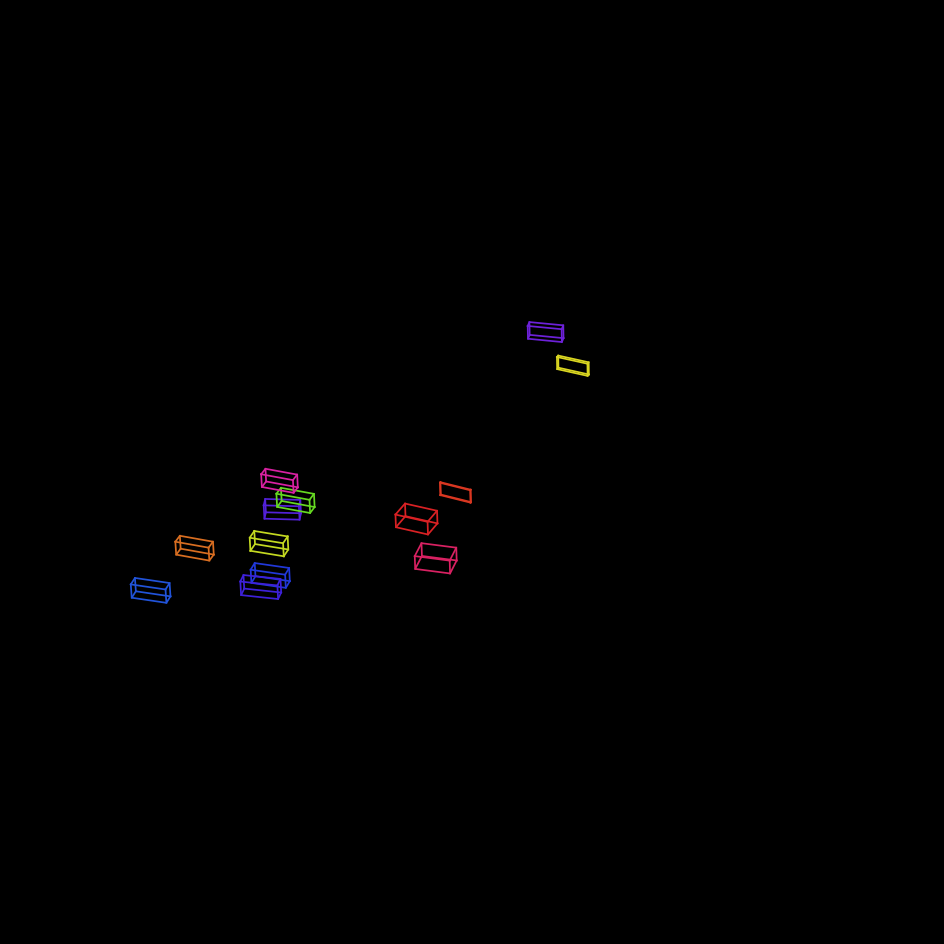

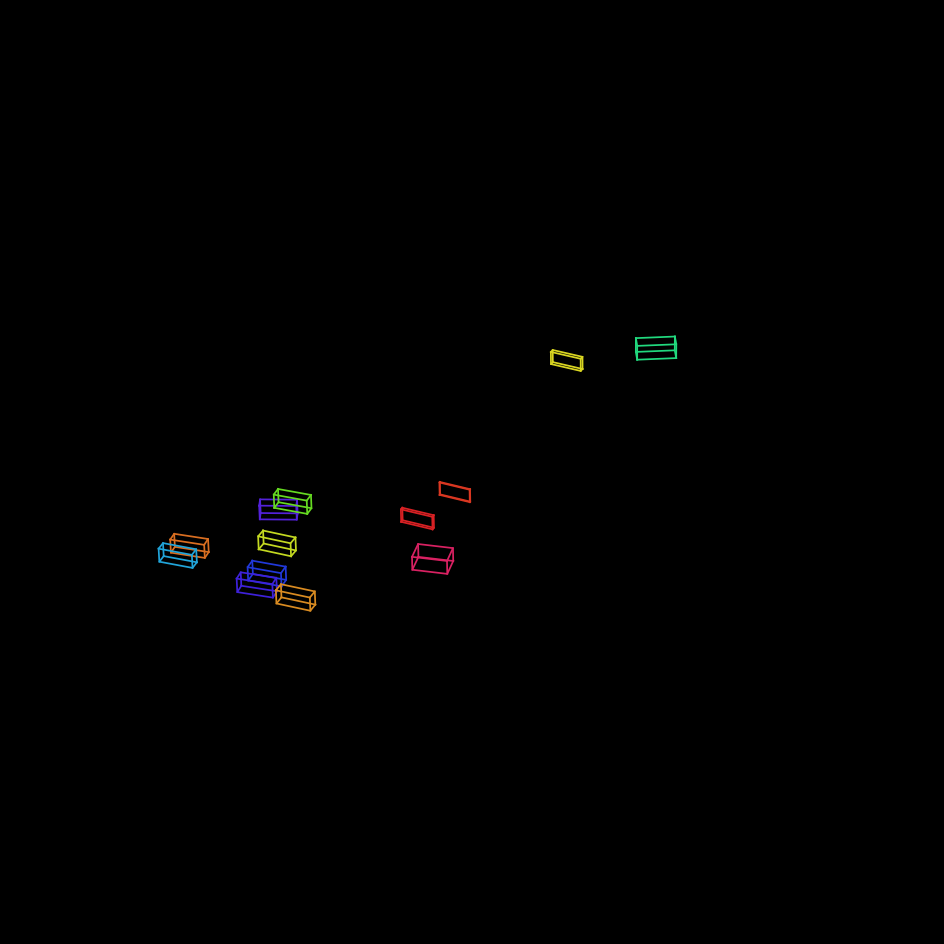

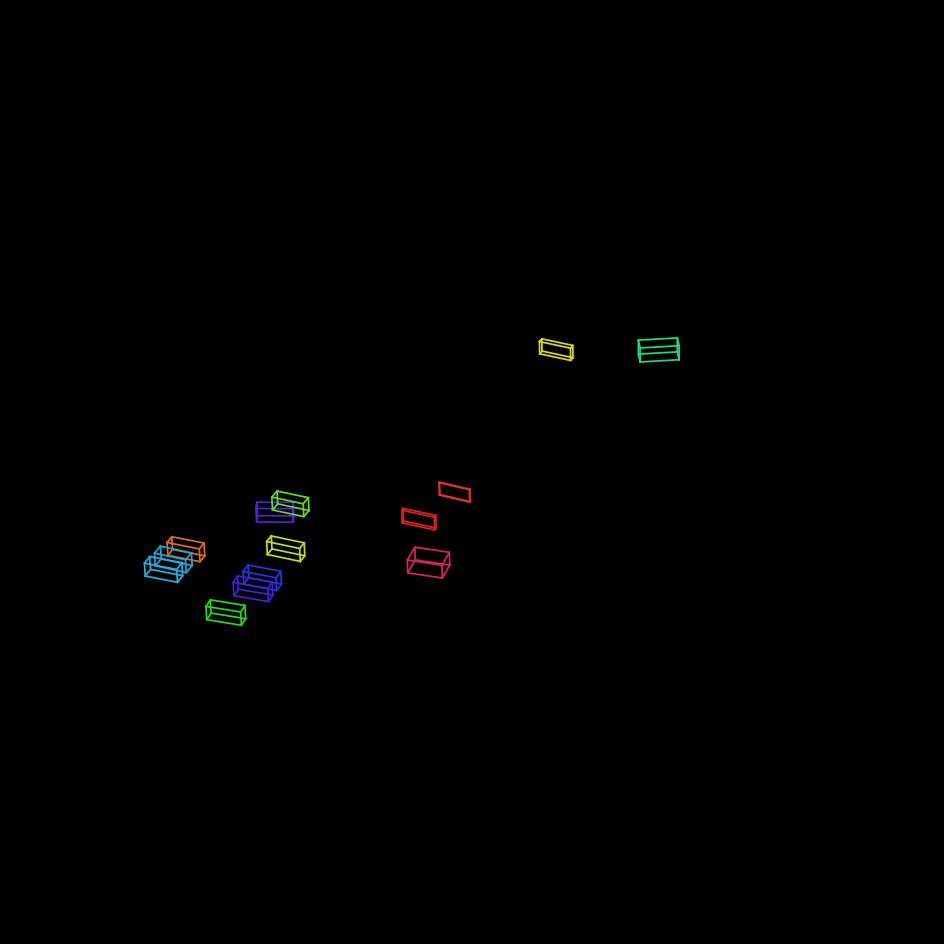

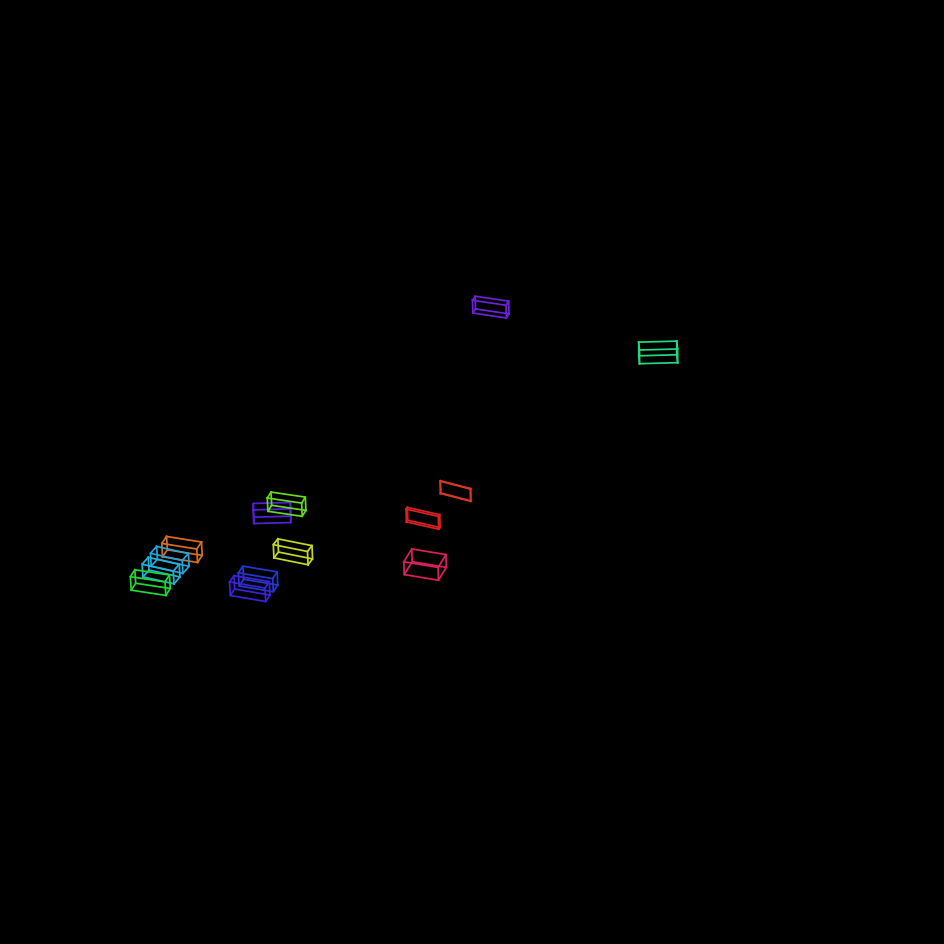

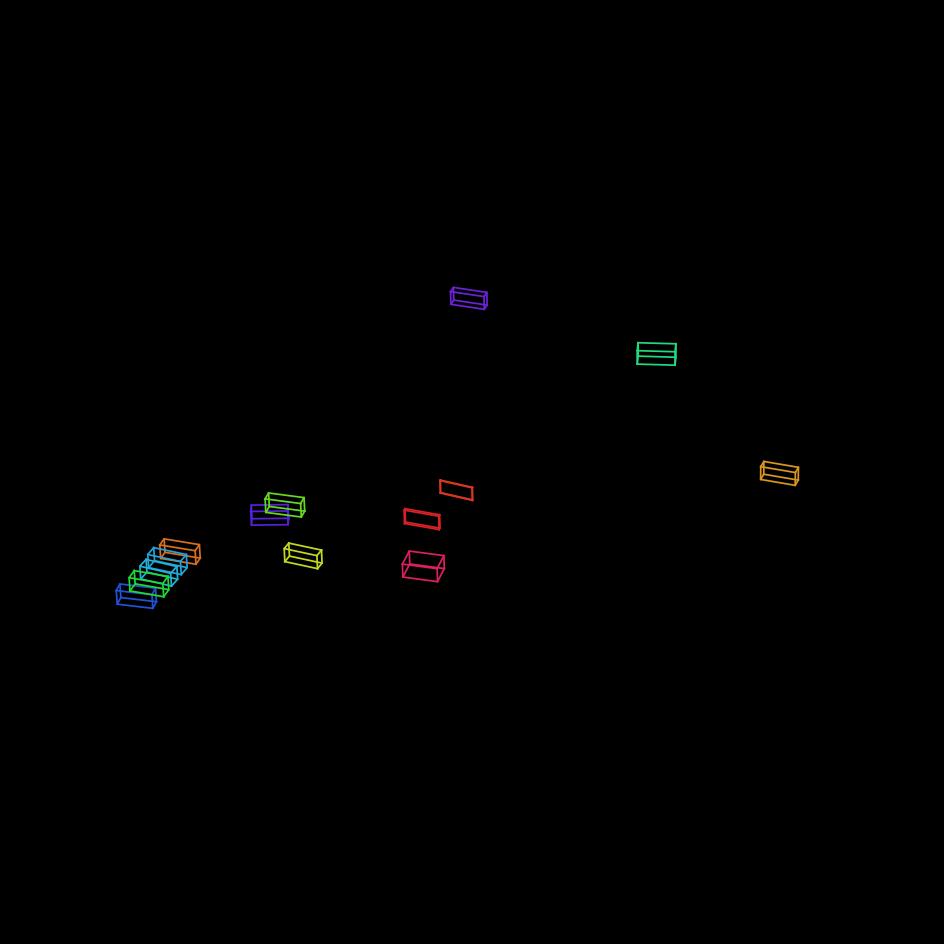

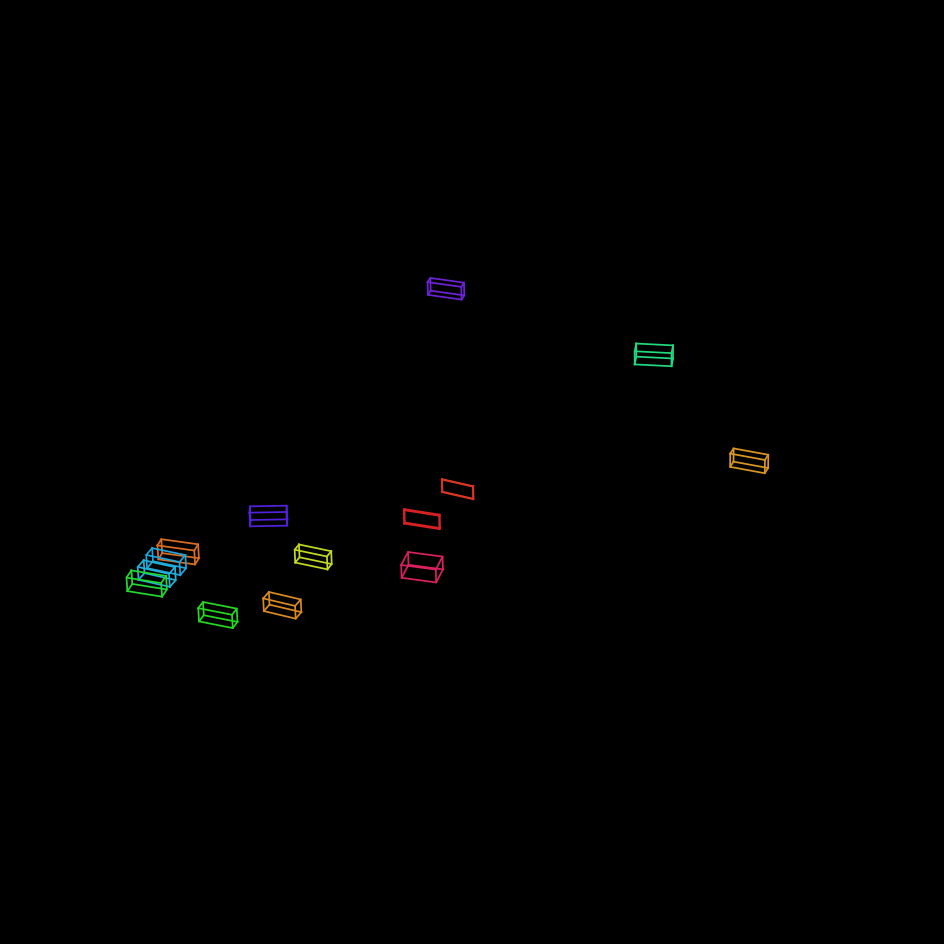

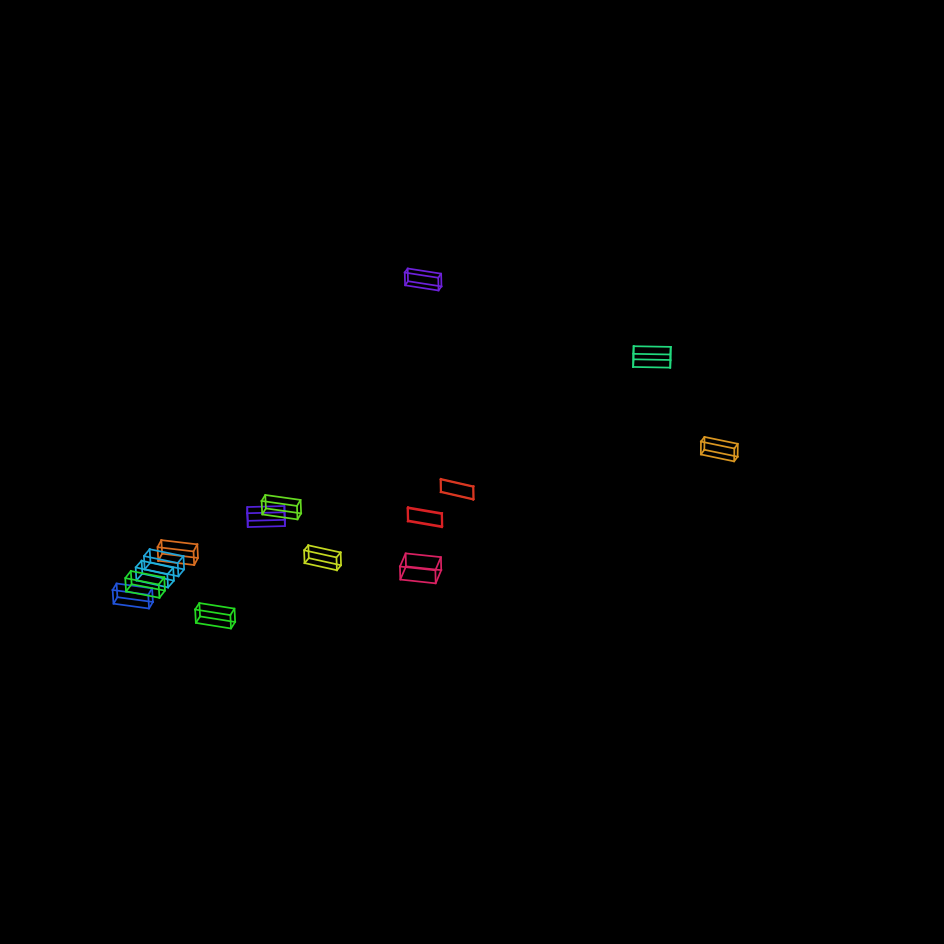

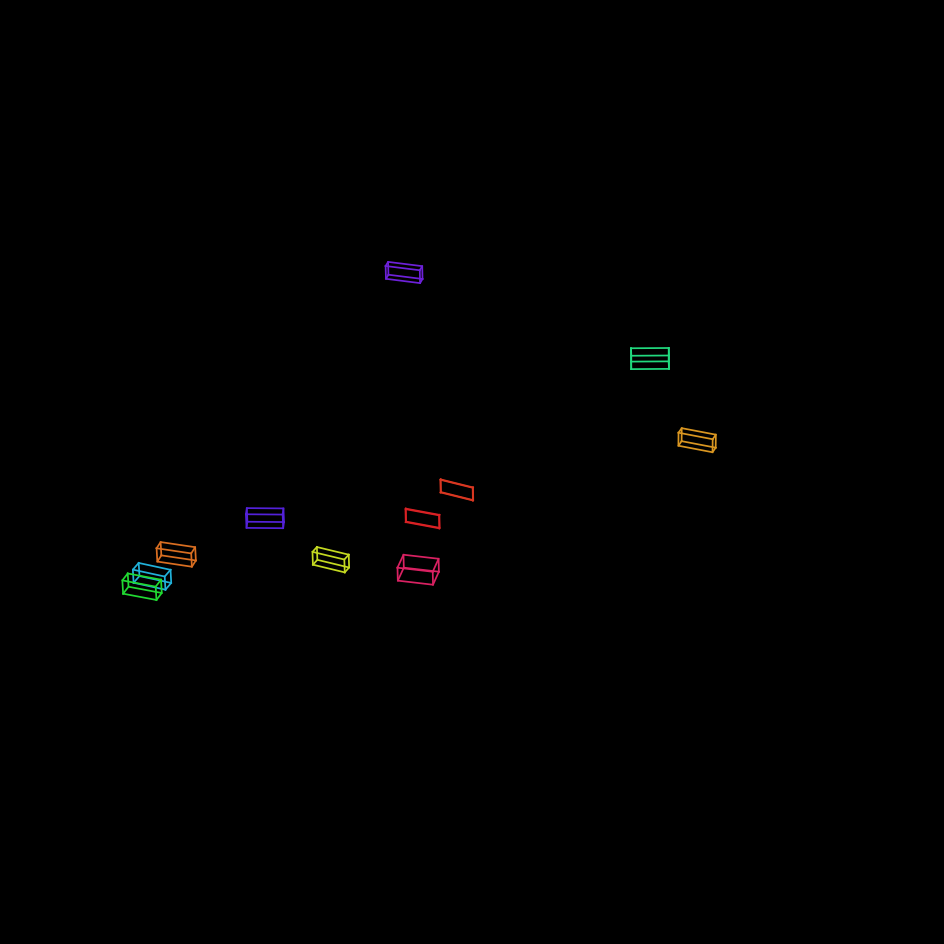

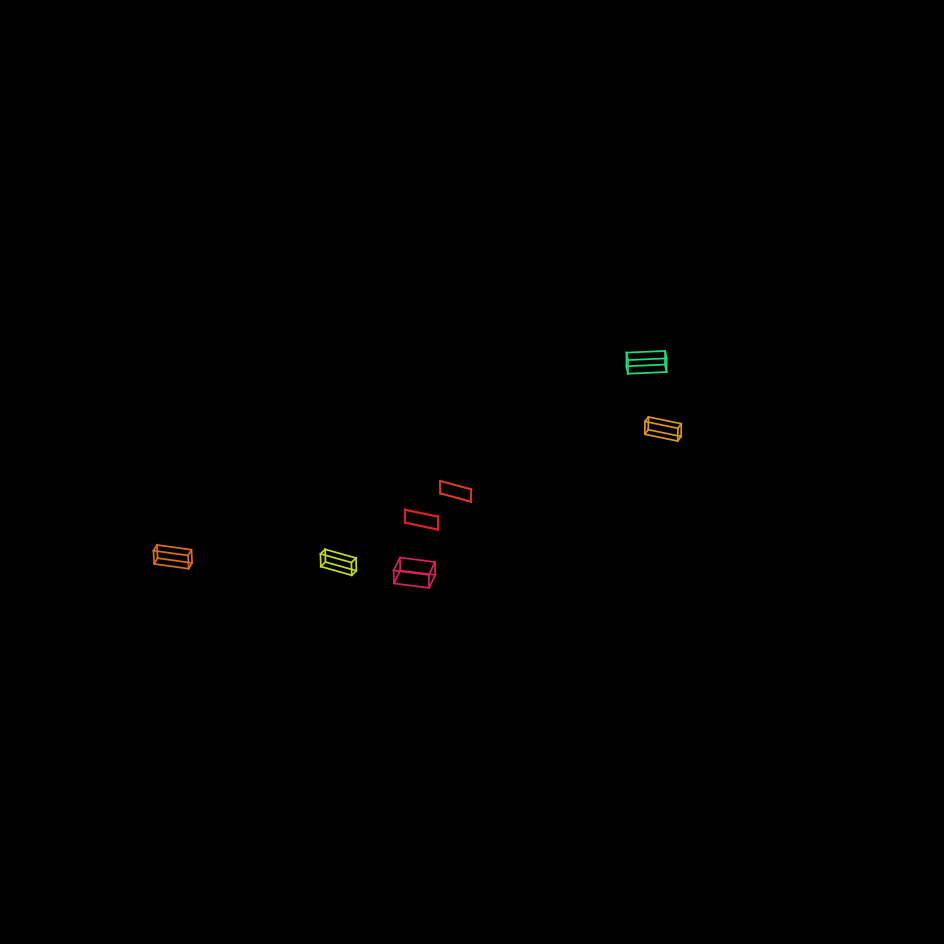

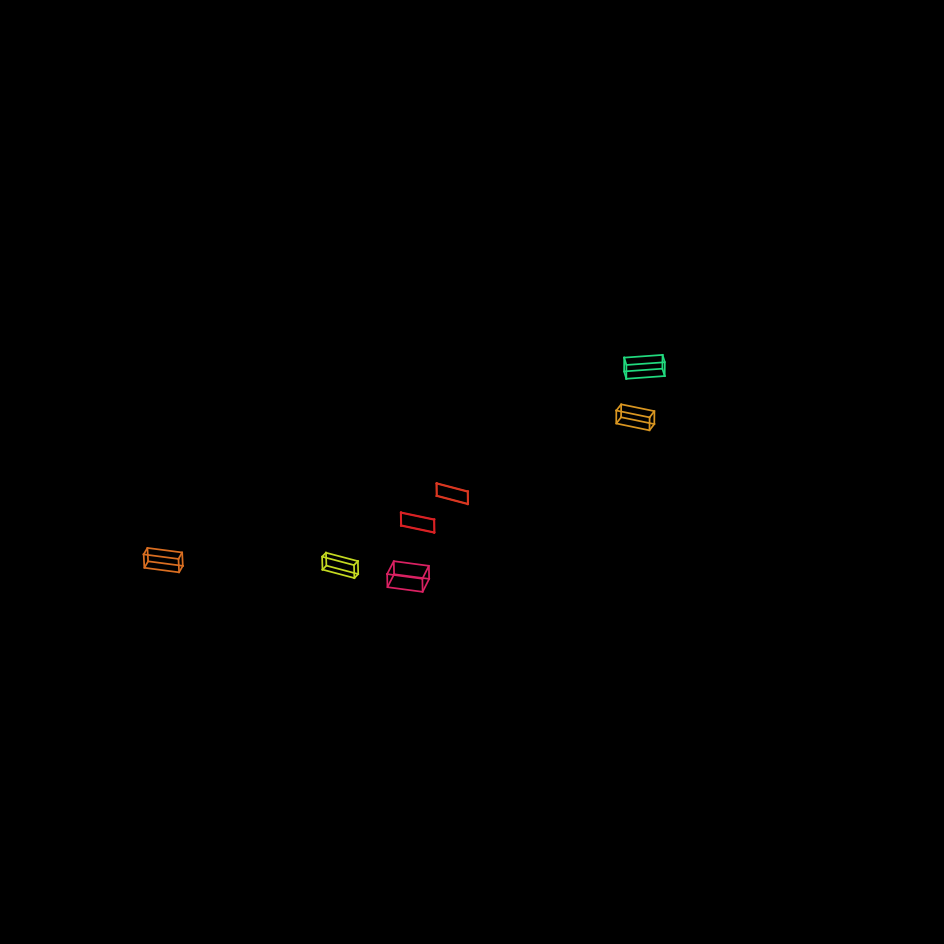

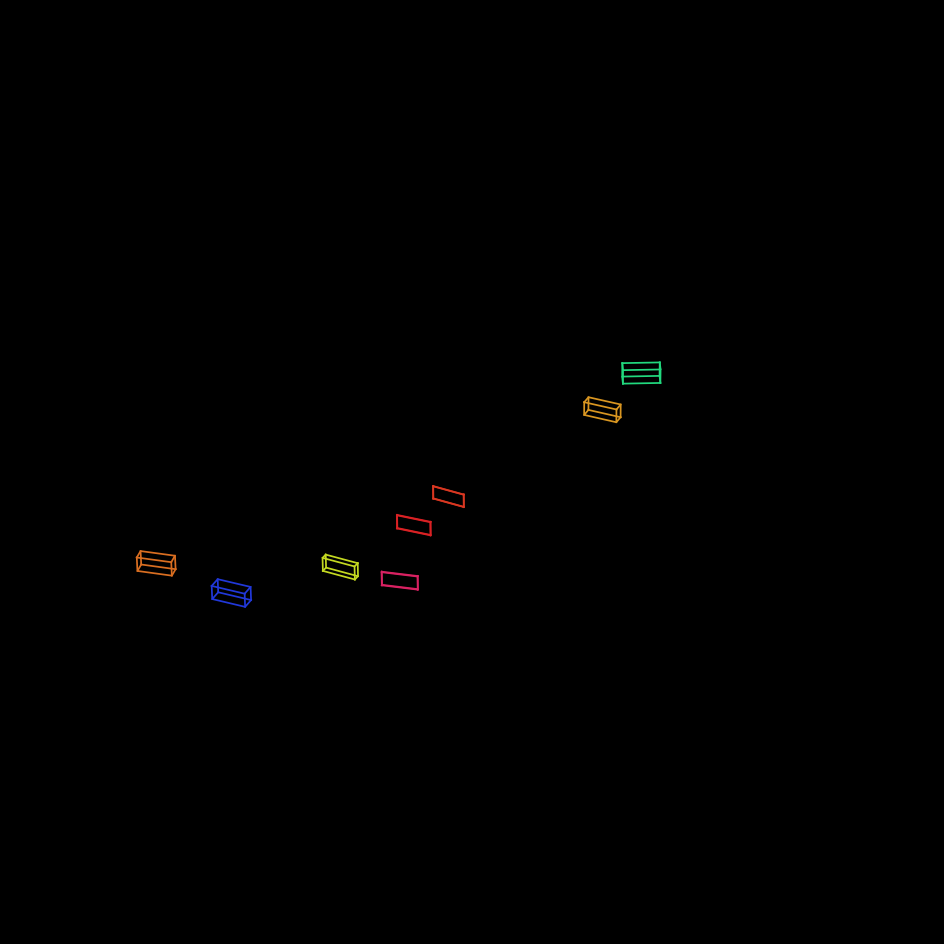

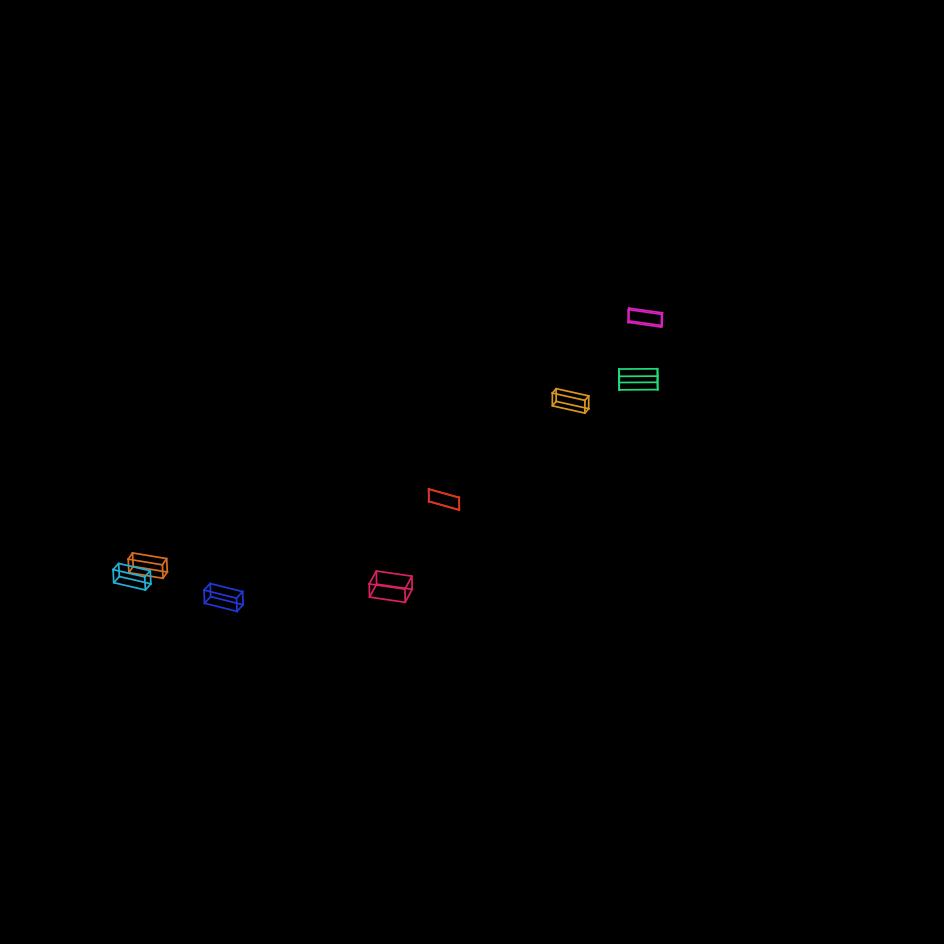

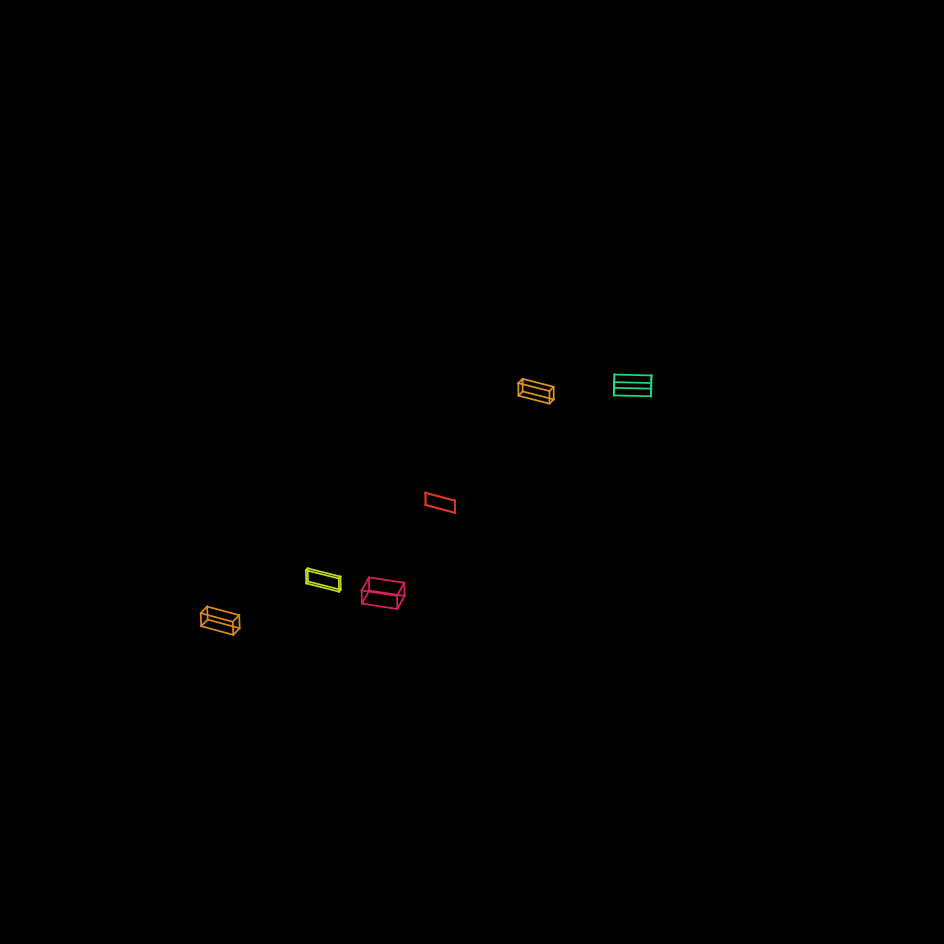

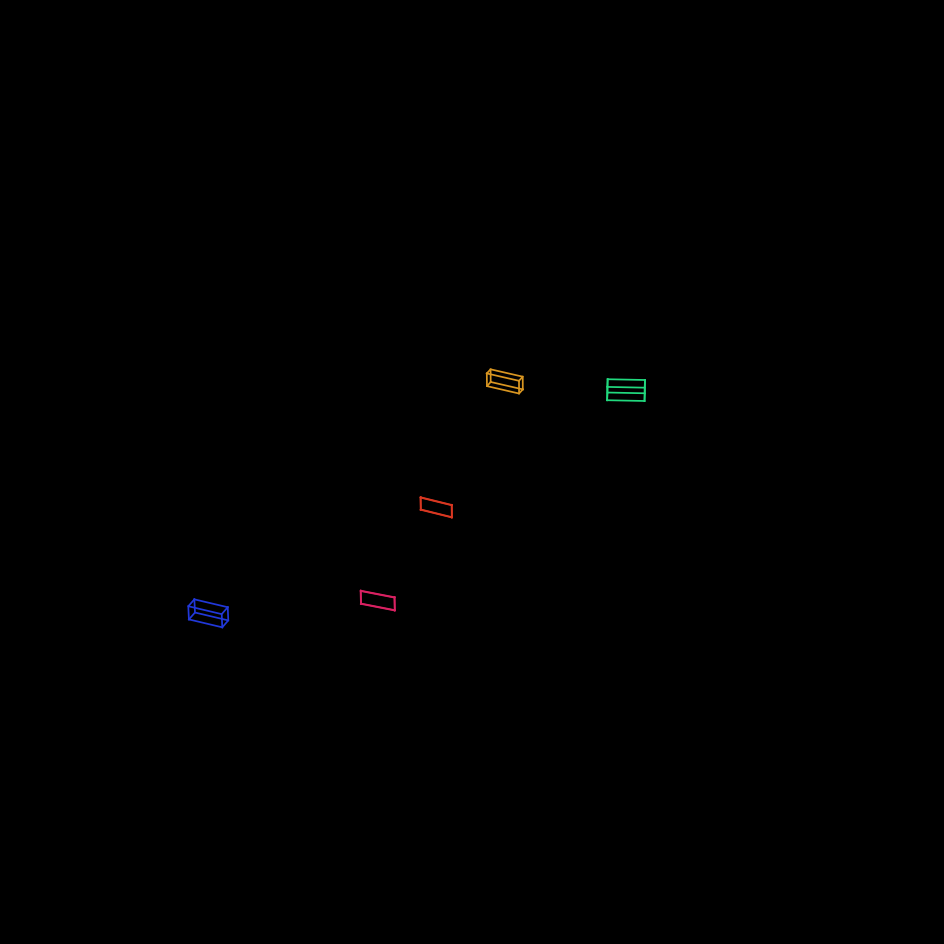

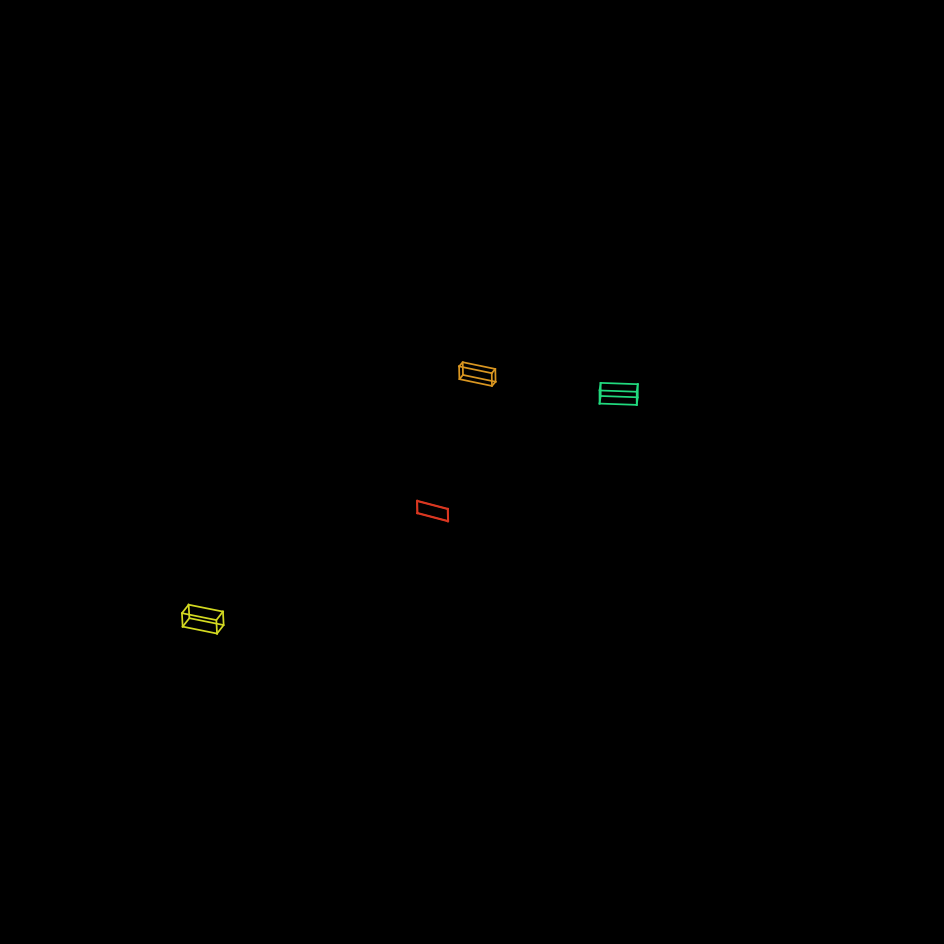

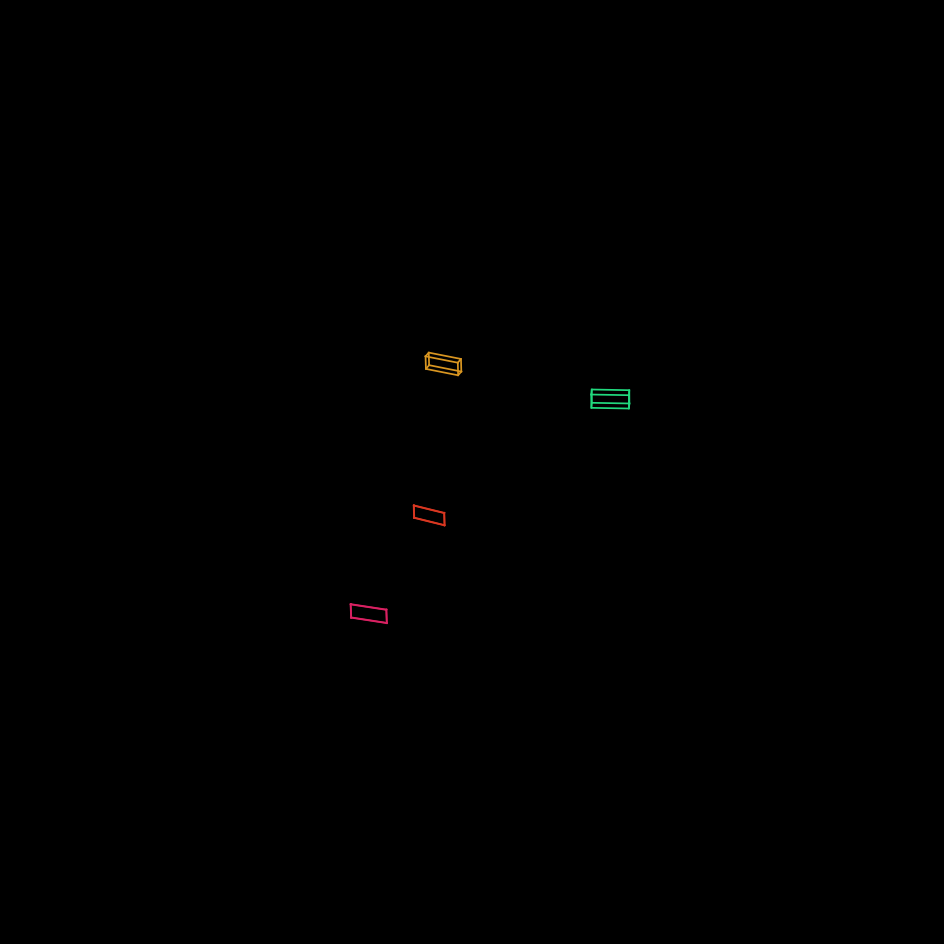

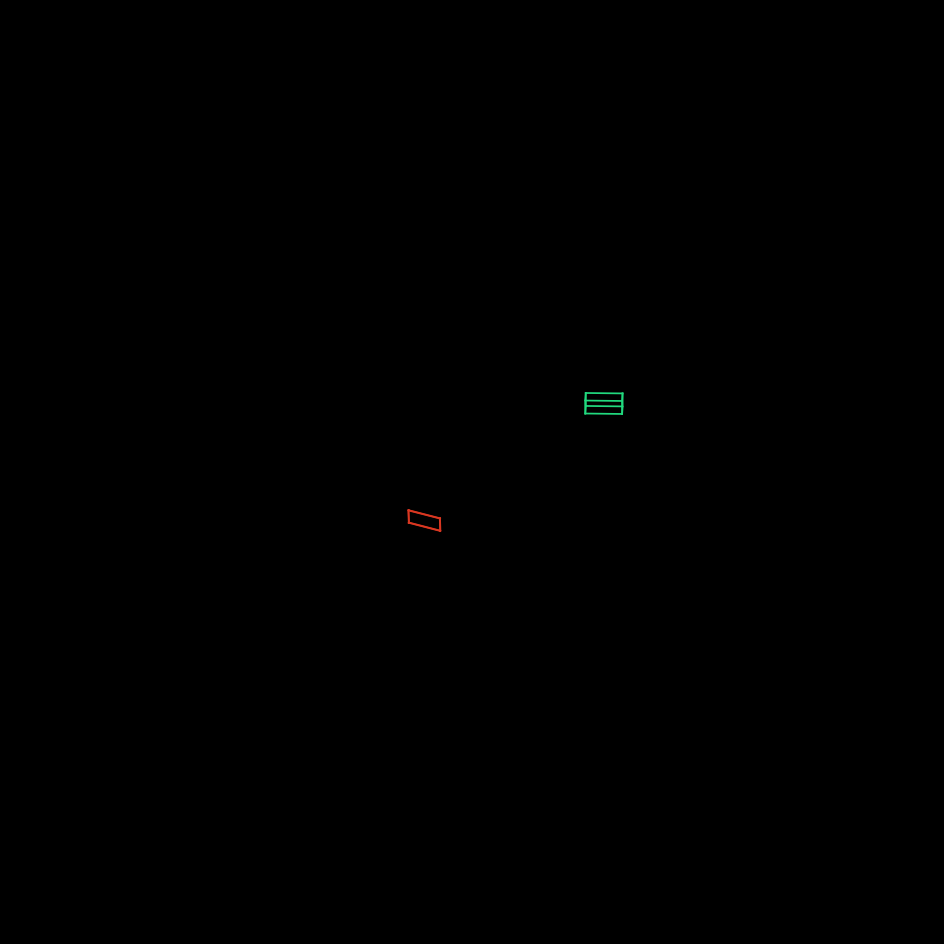

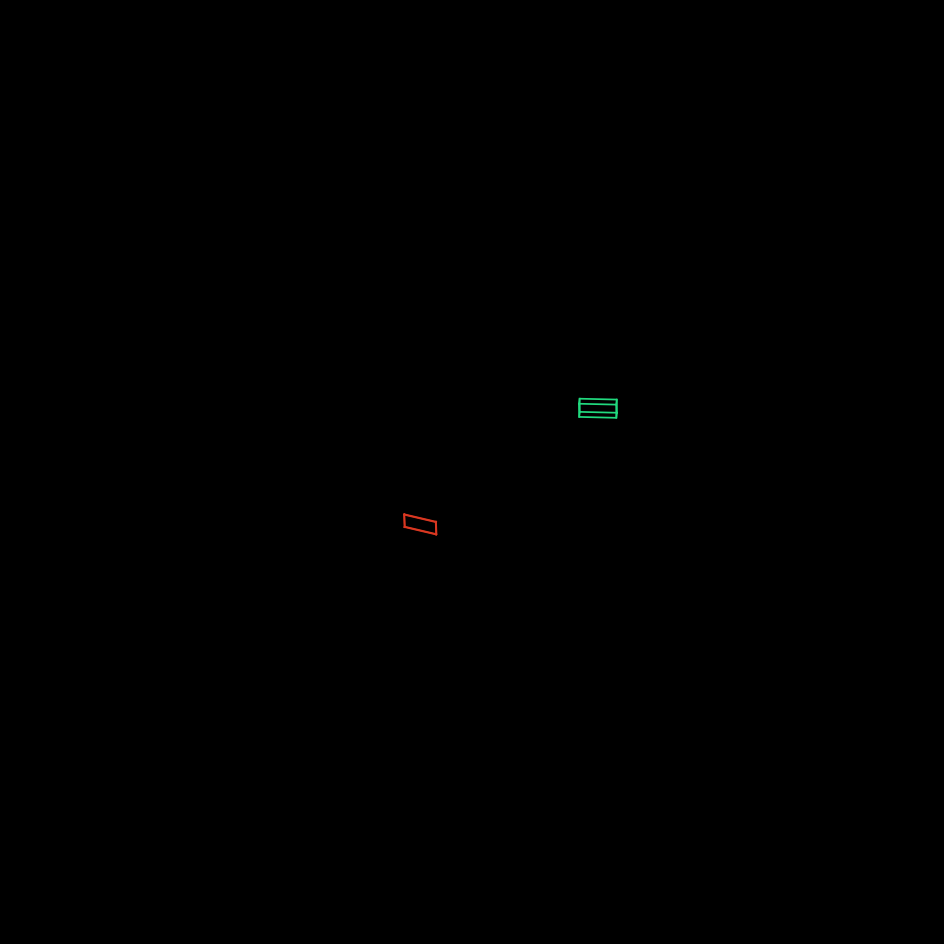

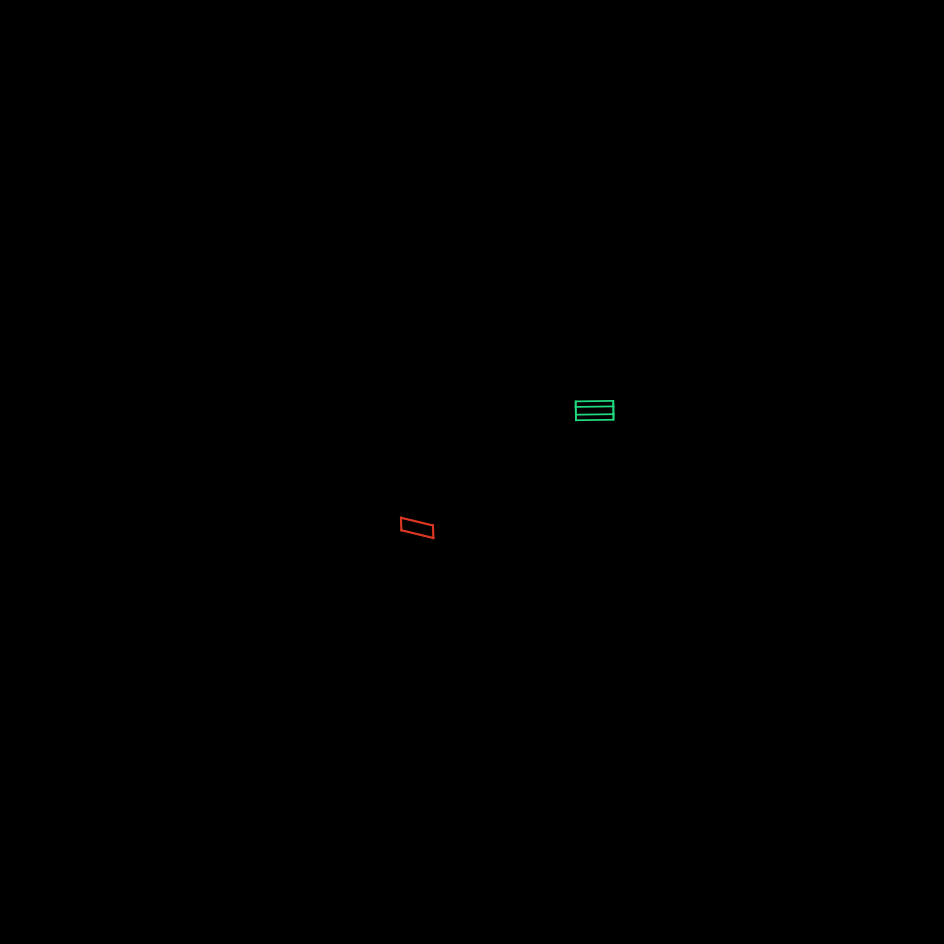

In [141]:
scene_idx: int = 0
score_threshold: float = 0.5
output_dir: Path = Path("~/visualizations").expanduser()
output_dir.mkdir(exist_ok=True, parents=True)

for frame_idx in range(40):
    
    # Get point cloud
    pc_npz = np.load(files["pc"][scene_idx])
    pc = pc_npz[pc_npz.files[frame_idx]]

    assert len(pc.shape) == 2, f"Expected 2D array, but got {pc.shape}"
    assert pc.shape[1] == 4, f"Expected 2D array with 4 columns (x,y,z,r), but got {pc.shape[1]} columns"

    # Get detections
    dets_npz = np.load(files["detection"][scene_idx], allow_pickle=True)
    dets: Dict[str, np.ndarray] = {
        "bboxes": dets_npz["bboxes"],
        "types": dets_npz["types"],
        "velos": dets_npz["velos"],
    }

    assert allequal(*[len(v) for v in dets.values()]), f"Number of detections must be the same. But got: {{k: len(v) for k, v in dets.items()}}"

    # Get calibration info
    calib_info_npz = np.load(files["calib_info"][scene_idx], allow_pickle=True)
    # print(calib_info_npz.files) # "0", "1" ... "40"
    calib_info = calib_info_npz[calib_info_npz.files[frame_idx]]
    assert len(calib_info) == 7, f"Expected 7D array, (x,y,z,Qx,Qy,Qz,Qw), but got {calib_info.shape}"
    # calib_info.shape
    calib_info_T = calib_info[:3]
    calib_info_Q = calib_info[3:]
    calib_info_R = Quaternion(calib_info_Q).rotation_matrix
    calib_info_tf = np.eye(4)
    calib_info_tf[:3, :3] = calib_info_R
    calib_info_tf[:3, 3] = calib_info_T

    # Get ego info
    ego_info_npz = np.load(files["ego_info"][scene_idx], allow_pickle=True)
    ego_info = ego_info_npz[ego_info_npz.files[frame_idx]]
    assert len(ego_info) == 7, f"Expected 7D array (x,y,z, Qx, Qy, Qz, Qw), but got {len(ego_info)}"
    T = ego_info[:3]
    Q = ego_info[3:]
    R = Quaternion(Q).rotation_matrix
    # Create a 4x4 transformation matrix.
    tf = np.eye(4)
    tf[:3, :3] = R
    tf[:3, 3] = T

    car_tracking_npz = np.load(files["car_tracking"][scene_idx], allow_pickle=True)

    car_tracking = {
        "ids": car_tracking_npz["ids"],
        "bboxes": car_tracking_npz["bboxes"],
        "states": car_tracking_npz["states"],
        "types": car_tracking_npz["types"],
    }

    assert allequal(*[len(v) for v in car_tracking.values()]), f"Number of car tracking must be the same. But got: {{k: len(v) for k, v in car_tracking.items()}}"

    car_tracklets: List[Tracklet] = []
    # for bbs, ids in zip(car_tracking["bboxes"][frame_idx], car_tracking["ids"][frame_idx]):
    for bb, tid, state, type in zip(*[car_tracking[k][frame_idx] for k in ["bboxes", "ids", "states", "types"]]):
        x, y, z, w, l, h, o, s = bb
        bbox = BBox(x=x, y=y, z=z, w=w, l=l, h=h, o=o)
        bbox.s = s
        car_tracklets.append(Tracklet(bbox, tracking_id=tid, state=state, type=type))

    tf_combined = np.dot(tf, calib_info_tf)
    output_path = output_dir / f"frame_{frame_idx:04d}_th_{score_threshold}.png"
    plot(None, [tkl for tkl in car_tracklets if tkl.bbox.s > score_threshold], zoom=3 ,tf=tf_combined, show=False, save=True, save_path=output_path)
    print(f"Generated image [{frame_idx:04d}/{40:04d}]: {output_path}")

In [ ]:



pc_path = f"/home/cv08f23/datasets/simpletrack/preprocessing/nuscenes_data/2hz/pc/raw_pc/scene-{scene_no}.npz"
dets_path = f"/home/cv08f23/datasets/simpletrack/preprocessing/nuscenes_data/2hz/detection/{det_names[0]}/dets/scene-{scene_no}.npz"
# tracking_path = f"/home/cv08f23/datasets/simpletrack/tracking/nuscenes_data/{det_names[0]}/debug/results/merged_output.json"
tracking_path = f"/home/cv08f23/datasets/simpletrack/tracking/nuscenes_data/cp/debug/summary/{label}/scene-{scene_no}.npz"
ego_info_path = f"/home/cv08f23/datasets/simpletrack/preprocessing/nuscenes_data/2hz/ego_info/scene-{scene_no}.npz"
calib_info_path = f"/home/cv08f23/datasets/simpletrack/preprocessing/nuscenes_data/2hz/calib_info/scene-{scene_no}.npz"

In [71]:
frame = 1

points = np.load(pc_path)
points = points[points.files[frame]]

# detections format
# [x, y, z, w, l, h, qx, qy, qz, qw, score]
dets = np.load(dets_path, allow_pickle=True)
pred_labels = np.array(dets["types"][frame])
dets = np.array(dets["bboxes"][frame])
print(dets[0])

[ 5.97970445e+02  1.50907911e+03  8.77843237e-01  1.89110982e+00
  4.52017069e+00  1.54134583e+00 -2.60372924e-01  2.22748059e-02
 -1.06183588e-02 -9.65192739e-01  9.01583016e-01]


In [63]:
# tracking = json.load(open(tracking_path, "r"))
# tracklets_all = create_tracklets(tracking["results"])
# tracklets = list(tracklets_all.values())[frame]
# token = list(tracklets_all.keys())[frame]
# print(token)

In [64]:
# ego pose format
# [x, y, z, qx, qy, qz, qw]
ego_info = np.load(ego_info_path, allow_pickle=True)
print(ego_info["0"])

ego_info = np.array(ego_info[ego_info.files[frame]])

# print(ego_info)

print(ego_info[:3])
print(ego_info[3:])

# print(Quaternion(ego_info[3:]).inverse.rotate(ego_info[:3]))

[ 5.93427563e+02  1.51144441e+03  0.00000000e+00 -2.65796802e-01
  3.98616992e-04 -2.87936170e-03 -9.64024694e-01]
[ 593.42756733 1511.44444909    0.        ]
[-2.65748454e-01  4.23927898e-04 -2.92683245e-03 -9.64037869e-01]


In [65]:
demo_ego_info_path = "/home/cv08f23/point-cloud-object-tracking/SimpleTrack/tools/demo_data/ego_info/segment-10203656353524179475_7625_000_7645_000_with_camera_labels.npz"
demo_ego_info = np.load(demo_ego_info_path, allow_pickle=True)
print(demo_ego_info[str(frame)])

[[-1.41700969e-01 -9.89229764e-01 -3.66784670e-02  7.21279155e+03]
 [ 9.89900107e-01 -1.41440837e-01 -9.60559532e-03 -1.56753373e+03]
 [ 4.31430771e-03 -3.76691406e-02  9.99280953e-01  2.11959000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [66]:
calib_info = np.load(calib_info_path, allow_pickle=True)
# print(calib_info.files)
calib_info = np.array(calib_info[calib_info.files[frame]])
print(calib_info)

[ 0.985793    0.          1.84019     0.70674924 -0.01530099  0.01739745
 -0.70708467]


In [93]:
tracking = np.load(tracking_path, allow_pickle=True)
print(tracking.files)
print(tracking["bboxes"][0][0])
assert len(tracking["bboxes"][0]) == len(tracking["ids"][0])
print(tracking["types"][30])

['ids', 'bboxes', 'states', 'types']
[5.97999401e+02 1.50906851e+03 8.56185318e-01 2.59485664e+00
 4.37171316e+00 1.82714081e+00 1.50655258e+00 9.02761698e-01]
['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']


In [ ]:
tracklets: List[Tracklet] = []
for bbs, ids in zip(tracking["bboxes"][frame], tracking["ids"][frame]):
    bbox = BBox(x=bbs[0], y=bbs[1], z=bbs[2], w=bbs[3], l=bbs[4], h=bbs[5], o=bbs[6])
    bbox.s = bbs[7]
    tracklets.append(Tracklet(bbox, tracking_id=ids))


print(tracklets[0])

In [94]:
# plot 3D point cloud
def plot_point_cloud(figure, points, calib, color=None):
    fig, ax = figure

    # pose_translation = np.array(pose['translation'])
    # pose_rotation = Quaternion(pose['rotation'])

    if color is None:
        distance = np.sqrt(np.sum(points[:,:3] ** 2, axis=1))
        normalized_distance = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
        colors = np.sqrt(normalized_distance ** (2/3))
    else:
        colors = color
    # print(points.shape)
    # print(pose_rotation._q_matrix())
    # r = R.from_quat([pose_rotation.x, pose_rotation.y, pose_rotation.z, pose_rotation.w])
    # rotation_matrix = r.as_matrix()

    # print(rotation_matrix.shape)
    # print(points[:,:3].shape)

    # points = np.dot(points[:,:3], rotation_matrix.T)

    # calib_translation = calib[:3]
    # calib_rotation = Quaternion(calib[3:])

    # points = np.dot(points[:,:3], calib_rotation.rotation_matrix.T)
    # points += calib_translation

    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=0.4, edgecolors="none", alpha=1, c=colors, cmap='jet')

generated_colors: Dict[str, np.ndarray] = {}

def plot_tracklets(figure, tracklets, pose):
    fig, ax = figure

    # det = dets[0]
    # label = pred_labels[0]

    pose_translation = pose[:3]
    pose_rotation = Quaternion(pose[3:])

    # pose_translation = np.array(pose['translation'])
    # pose_rotation = Quaternion(pose['rotation'])

    # Add each tracklet to the plot
    for tracklet in tracklets:
        # # print(tracklet)

        # # if (tracklet.tracking_score < 0.25):
        # #     continue

        # # 90 degree around z quaternion
        # # pose_rotation = Quaternion(axis=[0, 0, 1], angle=-np.pi/2)
        
        # center_x, center_y, center_z = pose_rotation.rotate(np.array(tracklet.translation) - pose_translation)
        # # center_x, center_y, center_z = tracklet.translation - pose_translation
        # l, w, h = tracklet.size
        # # rotation = Quaternion(tracklet.rotation) # * pose_rotation
        # yaw = tracklet.rotation # + pose_rotation.yaw_pitch_roll[0]

        # # bb = BBox()
        # # bb.x = center_x
        # # bb.y = center_y
        # # bb.z = center_z
        # # bb.l = l
        # # bb.w = w
        # # bb.h = h
        # # bb.o = yaw
        # # bb.s = tracklet.tracking_score

        
        corners = np.array(BBox.box2corners3d(tracklet.bbox))

        # translate to ego vehicle frame
        corners = corners - pose_translation
        # rotate to ego vehicle frame
        # corners = np.dot(corners, pose_rotation.rotation_matrix.T)
        # corners = pose_rotation.inverse.rotate(corners)


        # print(type(corners))

        # # print(BBox.bbox2world3d(np.expand_dims(pose, axis=1), bb))

        # # print(center_x, center_y, center_z, l, w, h, yaw)

        global generated_colors
        ID = tracklet.tracking_id
        if ID in generated_colors:
            color = generated_colors[ID]
        else:
            color = generate_hsv_color()
            generated_colors[ID] = color

        # # find the corners of the box
        # # center_x, center_y, center_z, l, w, h, yaw, _, _ = det

        # corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
        # corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
        # corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
        # points = np.hstack((corners_x, corners_y, corners_z))

        # # rotation matrix
        # R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
        #               [np.sin(-yaw),  np.cos(-yaw), 0],
        #               [           0,             0, 1]])
        # # rotate the box
        # points = points @ R
        # # points = rotation.rotate(points)

        # # offset the box with center position
        # points[:, 0] += center_x
        # points[:, 1] += center_y
        # points[:, 2] += center_z

        # colors
        # line_c = list(class_colors.values())[label]
        line_c = color
        line_a = 1
        line_w = 2

        # # plot 12 lines of bounding box
        # for i in range(4):
        #     ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        # for i in range(4):
        #     ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        # for i in range(4):
        #     ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=line_a, linewidth=line_w)

        # plot 12 lines of bounding box
        for i in range(4):
            ax.plot3D(corners[[i, i+4], 0], corners[[i, i+4], 1], corners[[i, i+4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(corners[[i, (i+1)%4], 0], corners[[i, (i+1)%4], 1], corners[[i, (i+1)%4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(corners[[i+4, (i+1)%4+4], 0], corners[[i+4, (i+1)%4+4], 1], corners[[i+4, (i+1)%4+4], 2], c=line_c, alpha=line_a, linewidth=line_w)

    


def plot_all(points, tracklets, pose, calib, zoom=1, title=None, show_axis=True, show=True, save_to_file=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # zooming. A higher zoom means a smaller area shown
    lim = (-100 / zoom, 100 / zoom) 
    ax.set_xlim3d(lim[0], lim[1])
    ax.set_ylim3d(lim[0], lim[1])
    ax.set_zlim3d(lim[0], lim[1])
    ax.set_axis_off()
    
    if show_axis:
        # ax.set_xlabel('X Label')
        # ax.set_ylabel('Y Label')
        # ax.set_zlabel('Z Label')
        pass
        
    plot_point_cloud((fig, ax), points, calib, color="white")
    # plot_tracklets((fig, ax), tracklets, pose)

    ax.set_aspect("equal", adjustable="box")
        
    if save_to_file:
        plt.savefig(f"img/vis/{title}.png", dpi=300)
    
    if show:
        plt.show()

/tmp/ipykernel_358808/3432493793.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=0.4, edgecolors="none", alpha=1, c=colors, cmap='jet')


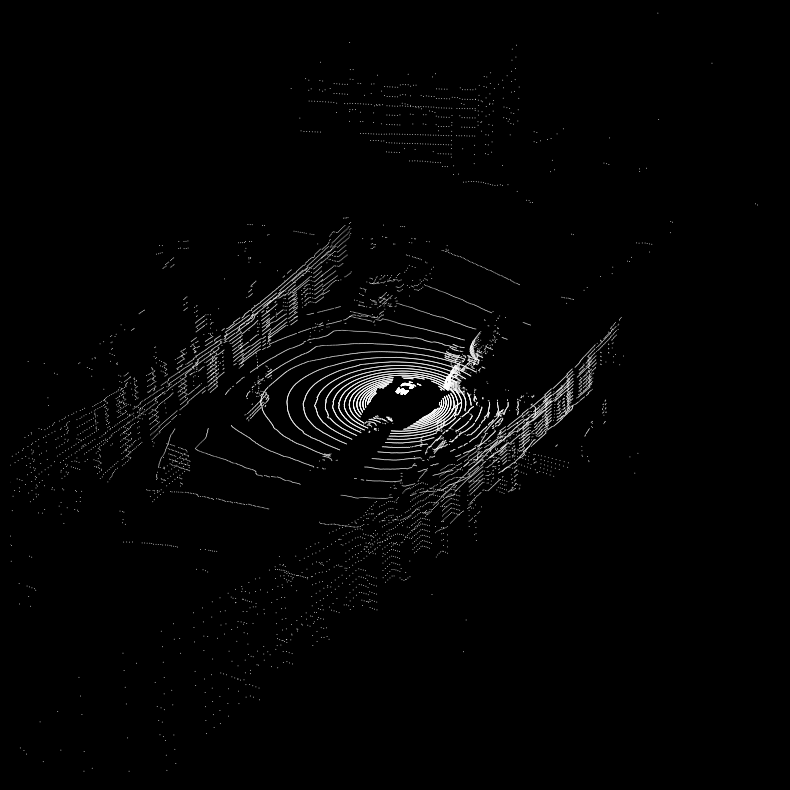

In [95]:
plot_all(points, tracklets, ego_info, calib_info, zoom=5, title="test", show_axis=True, show=True, save_to_file=False)